<h1 style="text-align: center;"><strong>Análisis exploratorio de datos (EDA)</strong></h1>


> # Etapa 1: Análisis descriptivo

---


- Instalación de librerias


In [1]:
# %pip install pyodbc
# %pip install ipython
# %pip install edaSQL
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install seaborn
# %pip install scipy

1. **Importamos los paquetes necesarios**


In [2]:
import edaSQL  # conexión a base datos
import pandas as pd
import numpy as np
import seaborn as sns  # visualización
import matplotlib.pyplot as plt  # visualización
from scipy import stats  # Datos atípicos

2.  **Establecer conexión con base datos**


In [3]:
try:
    edasql = edaSQL.SQL(printAll=True)

    edasql.connectToDataBase(
        server="localhost",
        database="TecnoNic_DW",
        user="sa",
        password="password",
        sqlDriver="ODBC Driver 17 for SQL Server"
    )
except Exception as e:
    print("A ocurrido un error con:", e)

========== Connected to DataBase Successfully ===========
Server:  localhost
DataBase:  TecnoNic_DW
User :  sa
Password :  password


2. **Cargamos la data en “dataframes”**


In [4]:
# Función para cargar las tablas a un dataframe
def loadTable(table_name):
    query = f"SELECT * FROM {table_name}"
    return pd.read_sql(query, edasql.dbConnection)


df_cliente = loadTable("dbo.dim_Cliente")
df_AreaEnvio = loadTable("dbo.dim_AreaEnvio")
df_ofertas = loadTable("dbo.dim_Ofertas")
df_pedido = loadTable("dbo.dim_Pedido")
df_producto = loadTable("dbo.dim_Producto")
df_ubicacion = loadTable("dbo.dim_Ubicacion")
df_envio = loadTable("dbo.Fact_Envio")

- Se fusionaron los conjuntos de datos para estructurar la información.


In [5]:
# uso de suffixes para corregir tablas con el mismo nombre
# uso de how = left para reflejar solamente datos relacionados con los envio 
df_envio = df_envio \
    .merge(df_pedido, left_on='Pedido Key', right_on='Pedido Key', how='left', suffixes=('', '_pedido')) \
    .merge(df_cliente, left_on='Cliente Key', right_on='Cliente Key', how='left', suffixes=('', '_cliente')) \
    .merge(df_ofertas, left_on='Oferta Key', right_on='Oferta Key', how='left', suffixes=('', '_ofertas')) \
    .merge(df_AreaEnvio, left_on='Area Envio Key', right_on='Area Envio Key', how='left', suffixes=('', '_area')) \
    .merge(df_producto, left_on='Producto Key', right_on='Producto Key', how='left', suffixes=('', '_producto')) \
    .merge(df_ubicacion, left_on='Ubicacion Key', right_on='Ubicacion Key', how='left', suffixes=('', '_ubicacion'))

- Definir índice


In [6]:
df_envio = df_envio.set_index("Envio Key")

- Limpieza de datos


In [7]:
# Definir nombre completo del cliente
df_envio['NombreCliente'] = df_envio['Nombre'] + ' ' + df_envio['Apellido']
df_envio.drop(columns=["Nombre", "Apellido"], inplace=True)

- Eliminar columnas innecesarias


In [8]:
columnsKeep = [
    'Envio Key', 'Metodo Pago', 'Direccion Pago', 'Precio Unitario', 'Cantidad', 'Estado', 'Fecha Pedido', 'NombreCliente', 'Puntos Fidelidad', 'Nombre_ofertas', 'Descuento',
    'Area', 'Costo Envio', 'Nombre_producto', 'Nombre Marca', 'Nombre Categoria', 'Empresa Envio', 'Metodo Envio', 'Estado envio', 'Ciudad', 'Fecha Envio', 'Fecha Entrega'
]

# Lista de todas las columnas en el DataFrame
allColumns = df_envio.columns.tolist()

# Lista de columnas a eliminar
columnsDrop = [col for col in allColumns if col not in columnsKeep]
df_envio = df_envio.drop(columns=columnsDrop)
df_envio.columns

Index(['Empresa Envio', 'Metodo Envio', 'Fecha Envio', 'Fecha Entrega',
       'Metodo Pago', 'Direccion Pago', 'Precio Unitario', 'Cantidad',
       'Estado', 'Fecha Pedido', 'Ciudad', 'Puntos Fidelidad',
       'Nombre_ofertas', 'Descuento', 'Area', 'Costo Envio', 'Nombre_producto',
       'Nombre Categoria', 'Nombre Marca', 'NombreCliente'],
      dtype='object')

- Organizar dataframe


In [9]:
columnOrder = [
    'NombreCliente', 'Puntos Fidelidad', # Cliente
    'Empresa Envio', 'Metodo Envio', 'Area', 'Costo Envio',  # Envio
    'Fecha Envio', 'Fecha Entrega', 'Fecha Pedido',  # Fechas importantes
    'Nombre_producto',   'Nombre Categoria', 'Nombre Marca',  # Producto
    'Precio Unitario', 'Cantidad', 'Metodo Pago', 'Nombre_ofertas', 'Descuento'  # Pedido
]

# Ordenar las columnas del DataFrame
df_envio = df_envio[columnOrder]
df_envio.columns

Index(['NombreCliente', 'Puntos Fidelidad', 'Empresa Envio', 'Metodo Envio',
       'Area', 'Costo Envio', 'Fecha Envio', 'Fecha Entrega', 'Fecha Pedido',
       'Nombre_producto', 'Nombre Categoria', 'Nombre Marca',
       'Precio Unitario', 'Cantidad', 'Metodo Pago', 'Nombre_ofertas',
       'Descuento'],
      dtype='object')

3. **Características de un DataFrame**


- Mostrar las primeras filas


In [10]:
df_envio.head(5)

,NombreCliente,Puntos Fidelidad,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Nombre_producto,Nombre Categoria,Nombre Marca,Precio Unitario,Cantidad,Metodo Pago,Nombre_ofertas,Descuento
Envio Key,,,,,,,,,,,,,,,,,
1,Muffin Baudinot,10.0,USPS,envio economico,island,87.07,2024-04-15,2023-09-27,2019-08-06,digital voice recorder,Electronics,TechMasters,957.59,38,Tarjeta de crédito,Unknown,0.00
2,Tamera McAvaddy,83.0,USPS,envio estandar,island,87.07,2024-04-09,2024-01-15,2022-02-23,wearable camera,Cameras,TechFusion,625.85,22,PayPal,Oferta de descuento en laptops,49.08
3,Casey Arney,69.0,DHL,envio estandar,desert,24.40,2024-02-26,2023-09-26,2019-06-23,smart pen,Keyboards and Mice,CyberTech,925.57,33,Tarjeta de crédito,Promoción de smartphones,24.07
4,Tonnie Douthwaite,3.0,UPS,envio estandar,coastal,81.20,2023-09-23,2024-04-29,2022-03-22,network switch,Gadgets,GizmoWorks,519.64,23,Tarjeta de crédito,Unknown,0.00
5,Robbert Manueli,87.0,FedEx,envio estandar,desert,24.40,2023-06-12,2023-06-15,2019-11-02,POS system,Virtual Reality,DigitalSolutions,1858.28,21,Efectivo,Promoción de smartphones,4.78


- Mostrar las ultimas filas


In [11]:
df_envio.tail(5)

,NombreCliente,Puntos Fidelidad,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Nombre_producto,Nombre Categoria,Nombre Marca,Precio Unitario,Cantidad,Metodo Pago,Nombre_ofertas,Descuento
Envio Key,,,,,,,,,,,,,,,,,
996,Mirabel McGuinness,6.0,Amazon Logistics,envio economico,rural,42.02,2024-01-07,2023-09-06,2020-09-26,wireless earbuds,Audio Devices,GadgetGalaxy,1346.53,30,Tarjeta de crédito,Promoción de smartphones,24.07
997,Amie Wisker,60.0,Amazon Logistics,envio economico,central,15.15,2024-03-26,2024-05-31,2023-08-17,graphic tablet,Drones,TechPro,1725.47,4,Tarjeta de crédito,Unknown,0.00
998,Elton Addy,24.0,UPS,envio estandar,valley,15.68,2023-12-18,2023-12-03,2019-04-13,VR headset,Monitors,GadgetZone,1303.04,13,PayPal,Promoción de smartphones,4.78
999,Pooh Founds,74.0,Amazon Logistics,envio expreso,downtown,80.77,2023-08-28,2024-05-26,2021-09-25,keyboard,Software,TechGenius,853.78,12,Tarjeta de crédito,Oferta de descuento en laptops,49.08
1000,Robby O'Neill,16.0,DHL,envio expreso,mountain,19.47,2024-01-05,2023-11-20,2022-12-27,external hard drive,External Hard Drives,DigitalDreams,1402.34,12,Efectivo,Promoción de smartphones,24.07


- Mostrar el número de filas y columnas del DataFrame ventas.


In [12]:
# El maenejo de f: no funciona  en jupyter notebook anaconda
try:
    print(f"Número de filas del dataframe: {df_envio.shape[0]} \nNúmero de columnas del dataframe: {df_envio.shape[1]}")
except AttributeError:
    print("Advertencia: El objeto no parece en anacando Juypter")
except Exception as e:
    print(f"Se produjo un error: {e}")

Número de filas del dataframe: 1000 
Número de columnas del dataframe: 17


- Resumen de la información interna sobre el DataFrame.


In [13]:
df_envio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1 to 1000
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   NombreCliente     996 non-null    object        
 1   Puntos Fidelidad  996 non-null    float64       
 2   Empresa Envio     1000 non-null   object        
 3   Metodo Envio      1000 non-null   object        
 4   Area              1000 non-null   object        
 5   Costo Envio       1000 non-null   float64       
 6   Fecha Envio       1000 non-null   datetime64[ns]
 7   Fecha Entrega     1000 non-null   datetime64[ns]
 8   Fecha Pedido      1000 non-null   datetime64[ns]
 9   Nombre_producto   979 non-null    object        
 10  Nombre Categoria  979 non-null    object        
 11  Nombre Marca      979 non-null    object        
 12  Precio Unitario   1000 non-null   float64       
 13  Cantidad          1000 non-null   int64         
 14  Metodo Pago       1000 non-nu

- Análisis descriptivos


In [14]:
df_envio.describe()

,Puntos Fidelidad,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Precio Unitario,Cantidad,Descuento
count,996.000000,1000.00000,1000,1000,1000,1000.000000,1000.000000,1000.000000
mean,50.411647,50.50802,2023-12-09 02:49:55.199999744,2023-12-11 19:30:43.199999744,2015-11-27 07:42:14.400000,964.216340,24.502000,29.675170
min,1.000000,15.15000,2023-06-10 00:00:00,2023-06-10 00:00:00,1753-01-01 00:00:00,0.000000,0.000000,0.000000
25%,26.000000,19.47000,2023-09-08 00:00:00,2023-09-04 00:00:00,2020-03-26 00:00:00,458.140000,12.000000,4.780000
50%,51.000000,42.02000,2023-12-10 00:00:00,2023-12-16 00:00:00,2021-07-15 12:00:00,934.380000,24.000000,24.070000
75%,76.000000,80.77000,2024-03-12 00:00:00,2024-03-11 06:00:00,2022-09-30 06:00:00,1484.485000,37.000000,49.080000
max,100.000000,87.07000,2024-06-09 00:00:00,2024-06-08 00:00:00,2023-12-30 00:00:00,1998.130000,50.000000,62.000000
std,28.613439,29.91585,NaN,NaN,NaN,594.841217,14.568055,22.658088


El análisis descriptivo del dataset revela varios aspectos clave sobre los pedidos de un sistema de fidelidad:

1. **Puntos de Fidelidad**: La mayoría de los clientes acumulan entre 26 y 76 puntos, con un promedio de 50.41 y una considerable variabilidad (desviación estándar de 28.61).

2. **Costo de Envío**: El costo promedio es de 50.51, con una amplia variabilidad (desviación estándar de 29.92), y la mitad de los envíos cuestan menos de 42.02.

3. **Fechas**: Las fechas de envío y entrega se centran alrededor de diciembre de 2023, mientras que las fechas de pedido muestran una amplia gama, incluyendo fechas iniciales que podrían ser errores ya que son datos generados.

4. **Precio Unitario**: Varía ampliamente con una media de 964.22 y una desviación estándar alta (594.84).

5. **Cantidad de Productos por Pedido**: Tiene una media de 24.50, con una distribución centrada alrededor de la mediana de 24.

6. **Descuentos**: Con una media de 29.68 y una distribución dispersa (desviación estándar de 22.66), indicando la presencia de descuentos significativos que afectan la media.

**Conclusiones Generales**:
- Se destaca la variabilidad en los datos, especialmente en precios, cantidades y descuentos.
- Las fechas de pedido deberían ser verificadas debido a posibles errores.
- La relación entre descuentos y precios unitarios es crucial para un análisis más profundo.

- Elimanar columnas innecesarias


In [15]:
df_envio.columns

Index(['NombreCliente', 'Puntos Fidelidad', 'Empresa Envio', 'Metodo Envio',
       'Area', 'Costo Envio', 'Fecha Envio', 'Fecha Entrega', 'Fecha Pedido',
       'Nombre_producto', 'Nombre Categoria', 'Nombre Marca',
       'Precio Unitario', 'Cantidad', 'Metodo Pago', 'Nombre_ofertas',
       'Descuento'],
      dtype='object')

In [16]:
df_envio = df_envio.drop(columns=[
    "Nombre Marca",
    "Nombre Categoria"
], axis=1)
df_envio.head()

,NombreCliente,Puntos Fidelidad,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Nombre_producto,Precio Unitario,Cantidad,Metodo Pago,Nombre_ofertas,Descuento
Envio Key,,,,,,,,,,,,,,,
1,Muffin Baudinot,10.0,USPS,envio economico,island,87.07,2024-04-15,2023-09-27,2019-08-06,digital voice recorder,957.59,38,Tarjeta de crédito,Unknown,0.00
2,Tamera McAvaddy,83.0,USPS,envio estandar,island,87.07,2024-04-09,2024-01-15,2022-02-23,wearable camera,625.85,22,PayPal,Oferta de descuento en laptops,49.08
3,Casey Arney,69.0,DHL,envio estandar,desert,24.40,2024-02-26,2023-09-26,2019-06-23,smart pen,925.57,33,Tarjeta de crédito,Promoción de smartphones,24.07
4,Tonnie Douthwaite,3.0,UPS,envio estandar,coastal,81.20,2023-09-23,2024-04-29,2022-03-22,network switch,519.64,23,Tarjeta de crédito,Unknown,0.00
5,Robbert Manueli,87.0,FedEx,envio estandar,desert,24.40,2023-06-12,2023-06-15,2019-11-02,POS system,1858.28,21,Efectivo,Promoción de smartphones,4.78


- Renombrar columnas


In [17]:
df_envio.columns

Index(['NombreCliente', 'Puntos Fidelidad', 'Empresa Envio', 'Metodo Envio',
       'Area', 'Costo Envio', 'Fecha Envio', 'Fecha Entrega', 'Fecha Pedido',
       'Nombre_producto', 'Precio Unitario', 'Cantidad', 'Metodo Pago',
       'Nombre_ofertas', 'Descuento'],
      dtype='object')

In [18]:
df_envio = df_envio.rename(columns={
    "NombreCliente": "Cliente",
    "Nombre_producto": "Producto",
    "Nombre_ofertas": "Oferta",}
)
df_envio.tail(5)

,Cliente,Puntos Fidelidad,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Producto,Precio Unitario,Cantidad,Metodo Pago,Oferta,Descuento
Envio Key,,,,,,,,,,,,,,,
996,Mirabel McGuinness,6.0,Amazon Logistics,envio economico,rural,42.02,2024-01-07,2023-09-06,2020-09-26,wireless earbuds,1346.53,30,Tarjeta de crédito,Promoción de smartphones,24.07
997,Amie Wisker,60.0,Amazon Logistics,envio economico,central,15.15,2024-03-26,2024-05-31,2023-08-17,graphic tablet,1725.47,4,Tarjeta de crédito,Unknown,0.00
998,Elton Addy,24.0,UPS,envio estandar,valley,15.68,2023-12-18,2023-12-03,2019-04-13,VR headset,1303.04,13,PayPal,Promoción de smartphones,4.78
999,Pooh Founds,74.0,Amazon Logistics,envio expreso,downtown,80.77,2023-08-28,2024-05-26,2021-09-25,keyboard,853.78,12,Tarjeta de crédito,Oferta de descuento en laptops,49.08
1000,Robby O'Neill,16.0,DHL,envio expreso,mountain,19.47,2024-01-05,2023-11-20,2022-12-27,external hard drive,1402.34,12,Efectivo,Promoción de smartphones,24.07


- Visualización final del DataFrame


In [19]:
df_envio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1 to 1000
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Cliente           996 non-null    object        
 1   Puntos Fidelidad  996 non-null    float64       
 2   Empresa Envio     1000 non-null   object        
 3   Metodo Envio      1000 non-null   object        
 4   Area              1000 non-null   object        
 5   Costo Envio       1000 non-null   float64       
 6   Fecha Envio       1000 non-null   datetime64[ns]
 7   Fecha Entrega     1000 non-null   datetime64[ns]
 8   Fecha Pedido      1000 non-null   datetime64[ns]
 9   Producto          979 non-null    object        
 10  Precio Unitario   1000 non-null   float64       
 11  Cantidad          1000 non-null   int64         
 12  Metodo Pago       1000 non-null   object        
 13  Oferta            1000 non-null   object        
 14  Descuento         1000 non-nu

4. **Modificación de un DataFrame**


- Eliminar datos duplicados


In [20]:
df_envio.count()

Cliente              996
Puntos Fidelidad     996
Empresa Envio       1000
Metodo Envio        1000
Area                1000
Costo Envio         1000
Fecha Envio         1000
Fecha Entrega       1000
Fecha Pedido        1000
Producto             979
Precio Unitario     1000
Cantidad            1000
Metodo Pago         1000
Oferta              1000
Descuento           1000
dtype: int64

In [21]:
df_envio = df_envio.drop_duplicates()
df_envio.count()

Cliente              996
Puntos Fidelidad     996
Empresa Envio       1000
Metodo Envio        1000
Area                1000
Costo Envio         1000
Fecha Envio         1000
Fecha Entrega       1000
Fecha Pedido        1000
Producto             979
Precio Unitario     1000
Cantidad            1000
Metodo Pago         1000
Oferta              1000
Descuento           1000
dtype: int64

- Agregar columnas al dataframe


In [22]:
# Agregar el costo final del pedido tomado en cuenta envio, descuento y la cantidad en respecto a su precio unitario.
df_envio['Costo Final'] = (
    (df_envio['Cantidad'] * df_envio['Precio Unitario'] +
     df_envio['Costo Envio']) * (1 - df_envio['Descuento'] / 100)
).round(2)
df_envio.head()

,Cliente,Puntos Fidelidad,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Producto,Precio Unitario,Cantidad,Metodo Pago,Oferta,Descuento,Costo Final
Envio Key,,,,,,,,,,,,,,,,
1,Muffin Baudinot,10.0,USPS,envio economico,island,87.07,2024-04-15,2023-09-27,2019-08-06,digital voice recorder,957.59,38,Tarjeta de crédito,Unknown,0.00,36475.49
2,Tamera McAvaddy,83.0,USPS,envio estandar,island,87.07,2024-04-09,2024-01-15,2022-02-23,wearable camera,625.85,22,PayPal,Oferta de descuento en laptops,49.08,7055.36
3,Casey Arney,69.0,DHL,envio estandar,desert,24.40,2024-02-26,2023-09-26,2019-06-23,smart pen,925.57,33,Tarjeta de crédito,Promoción de smartphones,24.07,23210.44
4,Tonnie Douthwaite,3.0,UPS,envio estandar,coastal,81.20,2023-09-23,2024-04-29,2022-03-22,network switch,519.64,23,Tarjeta de crédito,Unknown,0.00,12032.92
5,Robbert Manueli,87.0,FedEx,envio estandar,desert,24.40,2023-06-12,2023-06-15,2019-11-02,POS system,1858.28,21,Efectivo,Promoción de smartphones,4.78,37181.77


- Acceso por filas y columnas a un DataFrame


    Seleccionar las primeras 10 filas y las columnas de la 0 a la 5 (inclusive)


In [23]:
firstRow = df_envio.iloc[:10, :6]
firstRow

,Cliente,Puntos Fidelidad,Empresa Envio,Metodo Envio,Area,Costo Envio
Envio Key,,,,,,
1,Muffin Baudinot,10.0,USPS,envio economico,island,87.07
2,Tamera McAvaddy,83.0,USPS,envio estandar,island,87.07
3,Casey Arney,69.0,DHL,envio estandar,desert,24.40
4,Tonnie Douthwaite,3.0,UPS,envio estandar,coastal,81.20
5,Robbert Manueli,87.0,FedEx,envio estandar,desert,24.40
6,NaN,NaN,UPS,envio expreso,island,87.07
7,Halley Malmar,86.0,FedEx,envio expreso,rural,42.02
8,Krystal Vivien,16.0,UPS,envio estandar,valley,15.68
9,Beale McAnulty,29.0,UPS,envio expreso,mountain,19.47


     Seleccionar las últimas 5 filas y las columnas de la 10 a la 15 (inclusive)


In [24]:
lastRow = df_envio.iloc[-5:, 10:16]
lastRow

,Precio Unitario,Cantidad,Metodo Pago,Oferta,Descuento,Costo Final
Envio Key,,,,,,
996,1346.53,30,Tarjeta de crédito,Promoción de smartphones,24.07,30704.51
997,1725.47,4,Tarjeta de crédito,Unknown,0.00,6917.03
998,1303.04,13,PayPal,Promoción de smartphones,4.78,16144.74
999,853.78,12,Tarjeta de crédito,Oferta de descuento en laptops,49.08,5258.07
1000,1402.34,12,Efectivo,Promoción de smartphones,24.07,12792.34


    Seleccionar columnas 'Cliente', 'Producto', 'Fecha Pedido' y 'Cantidad' para todas las filas


In [25]:
selectedColumns = df_envio.loc[:, [
    'Cliente', 'Producto', 'Fecha Pedido', 'Cantidad']]
selectedColumns.head(5)

,Cliente,Producto,Fecha Pedido,Cantidad
Envio Key,,,,
1,Muffin Baudinot,digital voice recorder,2019-08-06,38
2,Tamera McAvaddy,wearable camera,2022-02-23,22
3,Casey Arney,smart pen,2019-06-23,33
4,Tonnie Douthwaite,network switch,2022-03-22,23
5,Robbert Manueli,POS system,2019-11-02,21


- Selección a través de condicionales


     Personas que han pagado a través de PayPal


In [26]:
PayPal = df_envio.loc[df_envio['Metodo Pago'] == 'PayPal']
try:
    print(f"{len(PayPal)} Personas han pagado a través de PayPal")
except AttributeError:
    print("Advertencia: El objeto no parece en anacando Juypter")

233 Personas han pagado a través de PayPal


    Filas donde el Area sea 'suburb' y la Cantidad sea mayor a 2


In [27]:
urbana_cantidad = df_envio.loc[(
    df_envio['Area'] == 'suburb') & (df_envio['Cantidad'] > 40)]
urbana_cantidad

,Cliente,Puntos Fidelidad,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Producto,Precio Unitario,Cantidad,Metodo Pago,Oferta,Descuento,Costo Final
Envio Key,,,,,,,,,,,,,,,,
46,Libbi Illing,4.0,DHL,envio economico,suburb,77.74,2024-02-04,2023-09-30,2022-11-10,thermal printer,998.48,41,Tarjeta de crédito,Venta flash de dispositivos electrónicos,62.00,15585.86
55,Yves Platt,9.0,DHL,envio economico,suburb,77.74,2023-08-24,2023-08-09,2022-12-07,POS system,730.78,45,PayPal,Unknown,0.00,32962.84
106,Derby Costan,80.0,FedEx,envio expreso,suburb,77.74,2024-03-04,2023-09-04,2021-12-25,router,82.61,45,Transferencia bancaria,Oferta de descuento en laptops,49.08,1932.51
213,Tessy Gosnold,24.0,FedEx,envio estandar,suburb,77.74,2023-09-06,2023-09-10,2022-05-26,printer,1791.05,42,Tarjeta de crédito,Unknown,0.00,75301.84
265,Zechariah Rodenhurst,34.0,FedEx,envio expreso,suburb,77.74,2024-06-03,2024-05-26,2021-08-29,portable charger,1568.51,50,Tarjeta de crédito,Oferta de descuento en laptops,49.08,39973.85
266,Catriona Sterling,91.0,DHL,envio economico,suburb,77.74,2024-01-14,2024-06-04,2021-04-04,satellite phone,1964.43,48,Transferencia bancaria,Oferta de descuento en laptops,49.08,48053.40
268,Rosella Malbon,10.0,DHL,envio economico,suburb,77.74,2024-06-03,2024-05-09,2021-11-14,smart ring,691.87,44,Transferencia bancaria,Unknown,0.00,30520.02
326,Alia Ida,7.0,UPS,envio expreso,suburb,77.74,2023-07-18,2023-08-30,2023-12-13,thermal printer,125.84,45,Transferencia bancaria,Unknown,0.00,5740.54
400,Nonna Fraczak,43.0,Amazon Logistics,envio estandar,suburb,77.74,2023-07-07,2024-05-11,2022-05-07,smart scale,139.04,44,Transferencia bancaria,Venta flash de dispositivos electrónicos,62.00,2354.29


     Seleccionar todos los pedidos donde la cantidad de productos sea mayor a 35, el precio unitario sea menor a 230, y el área sea 'Central' o 'suburb'


In [28]:
order = df_envio[(df_envio['Cantidad'] > 35) &
                 (df_envio['Precio Unitario'] < 230) &
                 (df_envio['Area'].isin(['suburb', 'central']))]
order

,Cliente,Puntos Fidelidad,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Producto,Precio Unitario,Cantidad,Metodo Pago,Oferta,Descuento,Costo Final
Envio Key,,,,,,,,,,,,,,,,
15,Prentice Joss,24.0,DHL,envio estandar,central,15.15,2024-01-11,2023-09-19,2023-09-01,headphones,57.92,38,PayPal,Oferta de descuento en laptops,49.08,1128.44
106,Derby Costan,80.0,FedEx,envio expreso,suburb,77.74,2024-03-04,2023-09-04,2021-12-25,router,82.61,45,Transferencia bancaria,Oferta de descuento en laptops,49.08,1932.51
182,Christiano Pointing,36.0,FedEx,envio economico,central,15.15,2023-06-25,2023-11-23,2019-12-21,video doorbell,211.78,39,PayPal,Oferta de descuento en laptops,49.08,4213.41
248,Gwendolyn Wyche,50.0,UPS,envio estandar,central,15.15,2024-03-07,2023-07-13,2021-04-24,keyboard,96.30,49,Efectivo,Oferta de descuento en laptops,49.08,2410.48
326,Alia Ida,7.0,UPS,envio expreso,suburb,77.74,2023-07-18,2023-08-30,2023-12-13,thermal printer,125.84,45,Transferencia bancaria,Unknown,0.00,5740.54
400,Nonna Fraczak,43.0,Amazon Logistics,envio estandar,suburb,77.74,2023-07-07,2024-05-11,2022-05-07,smart scale,139.04,44,Transferencia bancaria,Venta flash de dispositivos electrónicos,62.00,2354.29
729,Rafaelita McLise,12.0,USPS,envio expreso,central,15.15,2024-01-09,2023-08-11,2021-04-23,smart glasses,182.68,45,Transferencia bancaria,Promoción de smartphones,4.78,7842.08
899,Violet Ambroisin,16.0,USPS,envio estandar,central,15.15,2023-08-18,2023-11-09,2020-03-30,biometric scanner,56.57,36,PayPal,Venta flash de dispositivos electrónicos,62.00,779.63
973,Cairistiona Tollow,77.0,USPS,envio economico,central,15.15,2023-11-05,2023-12-23,2019-04-04,portable DVD player,46.13,36,Transferencia bancaria,Promoción de smartphones,24.07,1272.46


     Filtrar los pedidos cuyo costo de envío sea menor al promedio del costo de envío, y la fidelidad de puntos sea mayor a 90


In [29]:
averageCost = df_envio['Costo Envio'].mean()
orderTwo = df_envio[(df_envio['Costo Envio'] < averageCost) &
                    (df_envio['Puntos Fidelidad'] > 90)]
orderTwo

,Cliente,Puntos Fidelidad,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Producto,Precio Unitario,Cantidad,Metodo Pago,Oferta,Descuento,Costo Final
Envio Key,,,,,,,,,,,,,,,,
25,Cinderella Northen,92.0,UPS,envio estandar,rural,42.02,2024-01-03,2023-09-25,2023-11-10,router,1206.62,10,Tarjeta de crédito,Oferta de descuento en laptops,49.08,6165.51
47,Fredra Malster,100.0,Amazon Logistics,envio estandar,rural,42.02,2024-04-27,2023-11-11,2022-11-25,camera,883.10,36,Efectivo,Promoción de smartphones,4.78,30311.97
48,Gill Lanfranchi,98.0,Amazon Logistics,envio economico,desert,24.40,2023-07-03,2023-09-17,2020-06-15,printer,965.51,43,Tarjeta de crédito,Oferta de descuento en laptops,49.08,21152.85
62,Hamel Elster,94.0,DHL,envio estandar,mountain,19.47,2023-09-30,2023-10-20,2019-02-28,GPS device,651.86,7,Transferencia bancaria,Descuento en productos de audio y video,27.40,3326.89
93,Adlai McCurtin,97.0,Amazon Logistics,envio estandar,central,15.15,2023-12-08,2023-10-07,2023-10-03,gaming mouse,910.15,26,Transferencia bancaria,Promoción de smartphones,24.07,17979.50
96,Marguerite Howie,99.0,USPS,envio economico,rural,42.02,2023-09-17,2023-07-08,2022-03-05,network switch,616.75,6,Efectivo,Venta flash de dispositivos electrónicos,62.00,1422.16
107,Cherida Chopin,97.0,DHL,envio estandar,mountain,19.47,2024-02-16,2024-05-22,2019-05-09,thermal printer,1847.73,20,Tarjeta de crédito,Promoción de smartphones,4.78,35206.71
125,Brant Cassie,98.0,UPS,envio economico,desert,24.40,2024-01-22,2023-07-27,2021-11-11,monitor,796.72,2,Efectivo,Promoción de smartphones,24.07,1228.43
133,Allie Stuther,99.0,DHL,envio expreso,central,15.15,2023-07-04,2024-02-06,2020-12-31,fitness tracker,282.72,8,Tarjeta de crédito,Unknown,0.00,2276.91


4. **Visualizacion gráfico de barra Costo de envío por área**


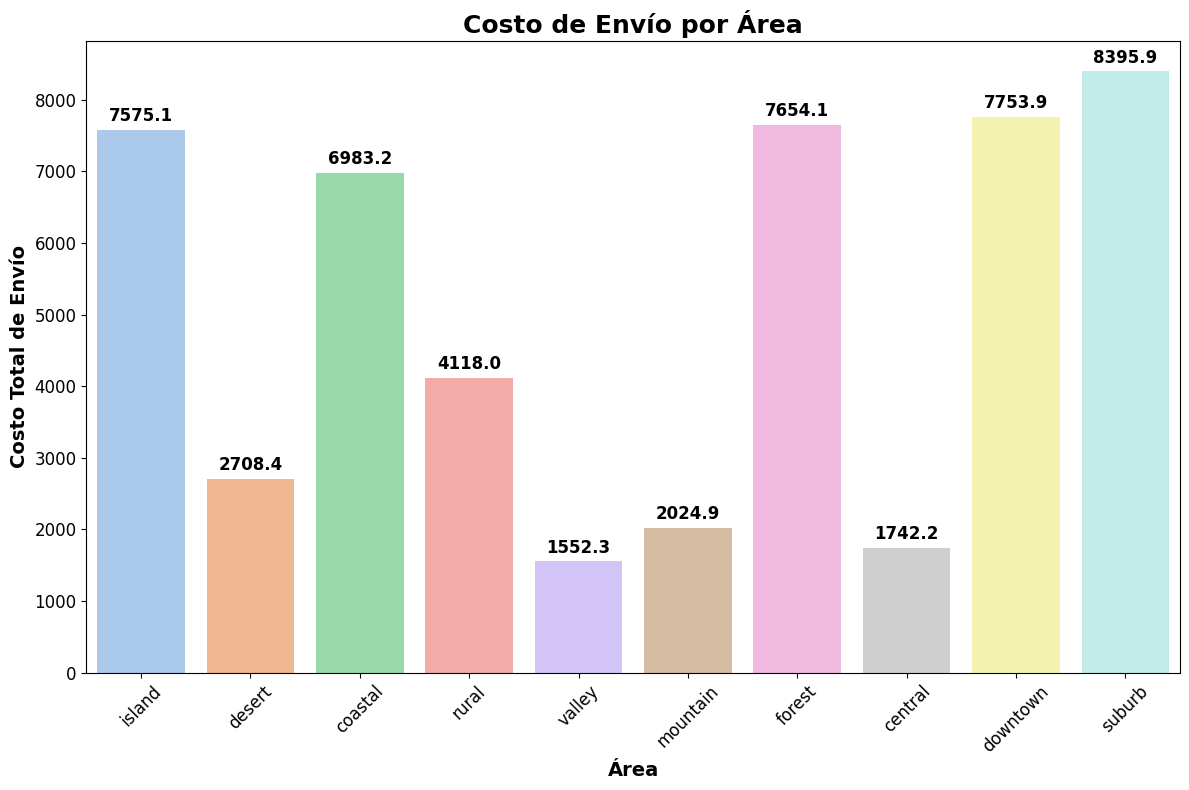

In [30]:
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='Area', y='Costo Envio', data=df_envio,
                      estimator=sum, ci=None, palette="pastel")
plt.title('Costo de Envío por Área', fontsize=18, fontweight='bold')
plt.xlabel('Área', fontsize=14, fontweight='bold')
plt.ylabel('Costo Total de Envío', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Añadir valores en la parte superior de las barras
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.1f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 10),
                     textcoords='offset points',
                     fontsize=12,
                     color='black',
                     fontweight='bold')

plt.show()

**Análisis del gráfico "Costo de Envío por Área"**

**Datos específicos**

Las siguientes son las observaciones específicas que se pueden hacer a partir del gráfico:

* El costo de envío más alto es para el área del **centro**.
* El costo de envío más bajo es para el área **rural**.
* Los costos de envío para las áreas **montañosa**, **boscosa** y **suburbana** son similares.
* Los costos de envío para las áreas **insular**, **desértica**, **costera** y del **valle** son similares.

**Conclusiones**

Los datos del grafico muestran que el costo de envío varía significativamente según el área. El costo de envío es más alto en las áreas urbanas y más bajo en las áreas rurales. Los costos de envío también se ven afectados por la topografía y el clima del área.

**Factores que pueden afectar el costo de envío**

Existen varios factores que pueden afectar el costo de envío, incluyendo:

* **Distancia:** El costo de envío generalmente aumenta con la distancia entre el punto de origen y el punto de destino.
* **Peso y dimensiones:** El costo de envío también depende del peso y las dimensiones del paquete. Los paquetes más pesados ​​y voluminosos generalmente cuestan más enviar.
* **Tipo de envío:** El tipo de envío que se elija también puede afectar el costo. Los envíos exprés o con seguimiento generalmente son más costosos que los envíos estándar.
* **Destino:** El costo de envío también puede variar según el destino. Los envíos a países o regiones con altos costos de transporte generalmente son más costosos.

**Recomendaciones**

Si se está buscando reducir los costos de envío, hay algunas cosas que se pueden hacer:

* **Compare precios:** Obtenga cotizaciones de diferentes compañías de envío antes de elegir una.
* **Elija el método de envío más económico:** Considere el peso y las dimensiones de su paquete y elija el método de envío más económico que satisfaga sus necesidades.
* **Envíe en grupos:** Si tiene varios paquetes para enviar, considere enviarlos juntos para obtener un descuento.
* **Utilice un servicio de envío consolidado:** Si está enviando a varios destinos, puede usar un servicio de envío consolidado para ahorrar dinero.


5. **Visualizacion gráficos de pastel de la distribución de pago**


In [31]:
df_envio['Metodo Pago'].unique()

array(['Tarjeta de crédito', 'PayPal', 'Efectivo',
       'Transferencia bancaria', 'Unknown'], dtype=object)

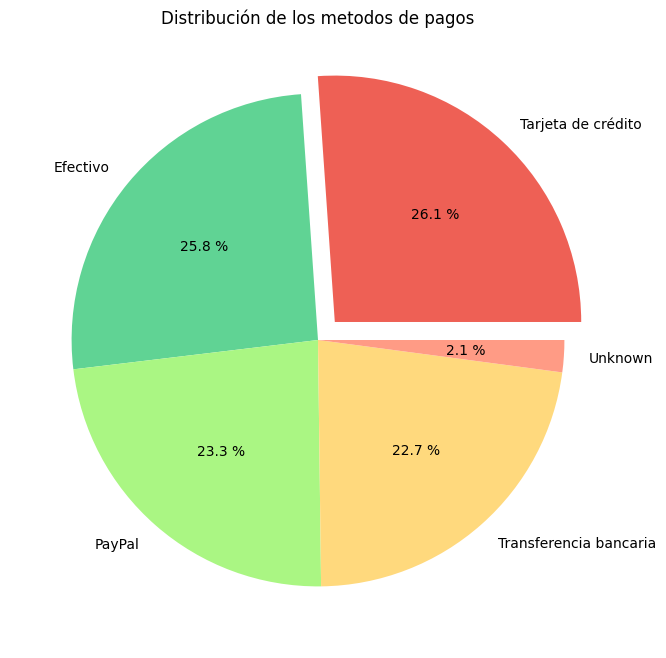

In [32]:
# Set the explode parameter for the pie chart
explode = (0.1, 0, 0, 0, 0)
plt.figure(figsize=(8, 8))
colors = ["#EE6055", "#60D394", "#AAF683", "#FFD97D", "#FF9B85"]
df_envio['Metodo Pago'].value_counts().plot.pie(
    autopct='%0.1f %%', explode=explode, colors=colors
)
plt.title('Distribución de los metodos de pagos')
plt.ylabel('')
plt.show()

**Análisis del gráfico de distribución de métodos de pago**

El gráfico de tarta muestra la distribución de los métodos de pago más utilizados para los  envios. El gráfico se divide en seis segmentos, cada uno de los cuales representa un método de pago diferente. Los porcentajes que aparecen junto a cada segmento indican la proporción de transacciones que se realizan con ese método de pago en particular.

**Los métodos de pago más populares**

Los tres métodos de pago más populares son:

* **Tarjeta de crédito:** Las tarjetas de crédito es el primer método de pago más popular, con una cuota de mercado del 26,1%. Las tarjetas de crédito ofrecen una serie de ventajas a los consumidores, como la posibilidad de pagar compras a plazos, acumular puntos de recompensa y obtener protección contra fraudes.

* **Efectivo:** El efectivo es el segundo método de pago más utilizado, con una cuota de mercado del 25,8%. Esto se debe en parte a que el efectivo es ampliamente aceptado y no requiere ningún tipo de tecnología especial para su uso.

* **PayPal:** PayPal es un servicio de pago en línea que permite a los consumidores enviar y recibir dinero sin necesidad de compartir su información financiera con los comerciantes. PayPal es el tercer método de pago más popular, con una cuota de mercado del 23,3%.

**Otros métodos de pago**

Los otros tres métodos de pago que se muestran en el gráfico son:

* **Transferencia bancaria:** Las transferencias bancarias son un método tradicional de pago que permite a los consumidores transferir dinero de una cuenta bancaria a otra. Las transferencias bancarias suelen ser más lentas y costosas que otros métodos de pago, pero pueden ser una buena opción para transferir grandes cantidades de dinero.
* **Desconocido:** El segmento "Desconocido" representa el 2,1% de las transacciones. Esto puede incluir transacciones que se han realizado con métodos de pago que no se enumeran en el gráfico, o transacciones para las que no se dispone de información sobre el método de pago.

**Tendencias en los métodos de pago**

El gráfico muestra que los métodos de pago más populares están cambiando. El uso de efectivo ha ido disminuyendo en los últimos años, mientras que el uso de tarjetas de crédito y servicios de pago en línea como PayPal ha ido aumentando. Esta tendencia probablemente continuará en el futuro, a medida que los consumidores se vuelvan más cómodos usando métodos de pago electrónicos.

> # Etapa 2: Ajuste de tipo de variables


1. **Tipos de datos**


In [33]:
df_envio.dtypes

Cliente                     object
Puntos Fidelidad           float64
Empresa Envio               object
Metodo Envio                object
Area                        object
Costo Envio                float64
Fecha Envio         datetime64[ns]
Fecha Entrega       datetime64[ns]
Fecha Pedido        datetime64[ns]
Producto                    object
Precio Unitario            float64
Cantidad                     int64
Metodo Pago                 object
Oferta                      object
Descuento                  float64
Costo Final                float64
dtype: object

1. Manejo de Fechas:


- Extraer componentes de fecha como día, mes, año, etc. solo para las columnas de interés


In [34]:
Order = df_envio.copy()
Order['Fecha Pedido'] = pd.to_datetime(Order['Fecha Pedido'])
Order['dia'] = Order['Fecha Pedido'].dt.day
Order['mes'] = Order['Fecha Pedido'].dt.month
Order['año'] = Order['Fecha Pedido'].dt.year

# Mostrar el DataFrame resultante
Order[['Cliente', 'Producto', 'Fecha Pedido', 'dia', 'mes', 'año']].head(5)

,Cliente,Producto,Fecha Pedido,dia,mes,año
Envio Key,,,,,,
1,Muffin Baudinot,digital voice recorder,2019-08-06,6,8,2019
2,Tamera McAvaddy,wearable camera,2022-02-23,23,2,2022
3,Casey Arney,smart pen,2019-06-23,23,6,2019
4,Tonnie Douthwaite,network switch,2022-03-22,22,3,2022
5,Robbert Manueli,POS system,2019-11-02,2,11,2019


- Cálculo de fechas


    Dias Transcurridos desde el envio hasta la fecha de entrega


In [35]:
shipment = df_envio.copy()
shipment['Dias Transcurridos desde el envio'] = (
    shipment['Fecha Entrega'] - shipment['Fecha Envio']).dt.days
# Las fechas son generadas asi que suponemos que no todas las fechas llevan una secuencia
shipment['Dias Transcurridos desde el envio'] = shipment['Dias Transcurridos desde el envio'].abs()
shipment[['Cliente', 'Producto', 'Cantidad', 'Fecha Entrega',
          'Fecha Envio', 'Dias Transcurridos desde el envio']].head(6)

,Cliente,Producto,Cantidad,Fecha Entrega,Fecha Envio,Dias Transcurridos desde el envio
Envio Key,,,,,,
1,Muffin Baudinot,digital voice recorder,38,2023-09-27,2024-04-15,201
2,Tamera McAvaddy,wearable camera,22,2024-01-15,2024-04-09,85
3,Casey Arney,smart pen,33,2023-09-26,2024-02-26,153
4,Tonnie Douthwaite,network switch,23,2024-04-29,2023-09-23,219
5,Robbert Manueli,POS system,21,2023-06-15,2023-06-12,3
6,NaN,digital photo frame,13,2024-04-06,2024-03-04,33


2.  **Manejo de Categorías**:


In [36]:
df_envio['Area'] = df_envio['Area'].astype('category')
df_envio['Producto'] = df_envio['Producto'].astype('category')
df_envio['Metodo Pago'] = df_envio['Metodo Pago'].astype('category')
df_envio['Oferta'] = df_envio['Oferta'].astype('category')

Las categorías que se han definido en el DataFrame `df_envio` tienen un significado específico y se utilizan para clasificar los datos de manera ordenada y eficiente. Aquí está el informe sobre el significado de estas categorías:

1. **Area:** Esta categoría representa las diferentes áreas o regiones a las que se envían los productos. En este caso, se han identificado cuatro áreas distintas donde se realizan los envíos.

2. **Producto:** Esta categoría se refiere a los distintos tipos de productos que se envían. El DataFrame actualmente contiene información sobre 50 productos diferentes que pueden estar siendo enviados.

3. **Método de Pago:** Esta categoría indica los diferentes métodos utilizados para realizar el pago de los productos. El DataFrame registra cinco métodos de pago diferentes que pueden estar asociados a los envíos.

4. **Oferta:** Aquí se registran las diferentes ofertas o promociones aplicadas a los envíos. El DataFrame muestra información sobre cuatro ofertas específicas que pueden haber sido utilizadas en los envíos.

Estas categorías son útiles para organizar y analizar los datos de envíos de manera más precisa y para realizar análisis posteriores sobre patrones de compra, preferencias de pago, efectividad de ofertas, entre otros aspectos relevantes para la gestión de envíos y ventas.


In [37]:
df_envio.dtypes

Cliente                     object
Puntos Fidelidad           float64
Empresa Envio               object
Metodo Envio                object
Area                      category
Costo Envio                float64
Fecha Envio         datetime64[ns]
Fecha Entrega       datetime64[ns]
Fecha Pedido        datetime64[ns]
Producto                  category
Precio Unitario            float64
Cantidad                     int64
Metodo Pago               category
Oferta                    category
Descuento                  float64
Costo Final                float64
dtype: object

> # Etapa 3: Detección y tratamientos de datos ausentes:


- Comprobar valores nulos


In [38]:
df_envio.isna().sum()

Cliente              4
Puntos Fidelidad     4
Empresa Envio        0
Metodo Envio         0
Area                 0
Costo Envio          0
Fecha Envio          0
Fecha Entrega        0
Fecha Pedido         0
Producto            21
Precio Unitario      0
Cantidad             0
Metodo Pago          0
Oferta               0
Descuento            0
Costo Final          0
dtype: int64

In [39]:
df_envio = df_envio.dropna()

In [40]:
df_envio.isna().sum()

Cliente             0
Puntos Fidelidad    0
Empresa Envio       0
Metodo Envio        0
Area                0
Costo Envio         0
Fecha Envio         0
Fecha Entrega       0
Fecha Pedido        0
Producto            0
Precio Unitario     0
Cantidad            0
Metodo Pago         0
Oferta              0
Descuento           0
Costo Final         0
dtype: int64

> # Etapa 4: Identificación y tratamiento de datos atípicos:


1. **Histograma**


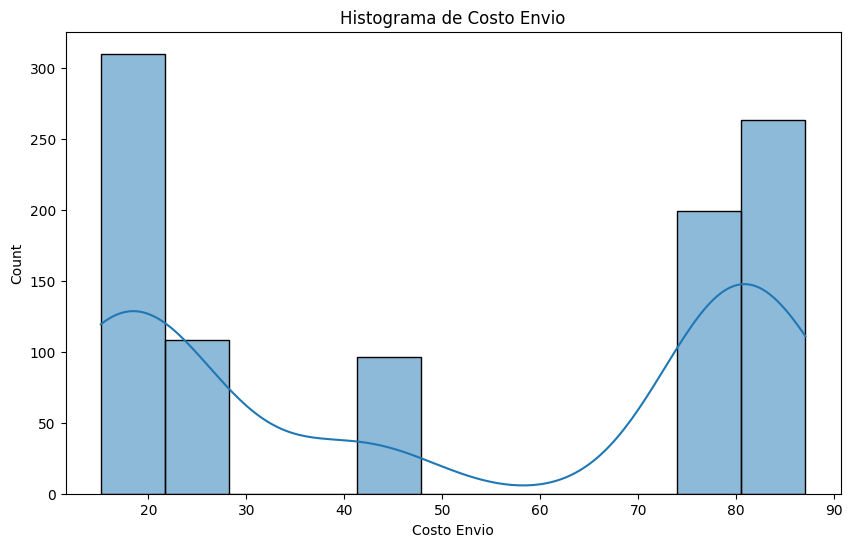

In [41]:
plt.figure(figsize=(10, 6))
sns.histplot(df_envio['Costo Envio'], kde=True)
plt.title('Histograma de Costo Envio')
plt.show()

**Análisis del histograma de costo de envío**

**Descripción del histograma**

El histograma muestra la distribución del costo de envío de un conjunto de envíos. El eje x representa el costo de envío, mientras que el eje y representa el número de envíos para cada rango de costo de envío.

**Interpretación del histograma**

El histograma muestra que la mayoría de los envíos tienen un costo de envío entre \$20 y \$40. Hay un pequeño número de envíos que tienen un costo de envío muy bajo o muy alto.

**Información que se puede obtener del histograma**

* El costo de envío promedio es de aproximadamente \$30.
* La mediana del costo de envío es de aproximadamente \$25.
* La moda del costo de envío es de aproximadamente \$30.
* El rango del costo de envío es de \$0 a \$90.
* La desviación estándar del costo de envío es de aproximadamente \$15.

**Conclusiones**

El histograma muestra que el costo de envío varía considerablemente entre los diferentes envíos. La mayoría de los envíos tienen un costo de envío entre \$20 y \$40.

2. **BoxPlot**


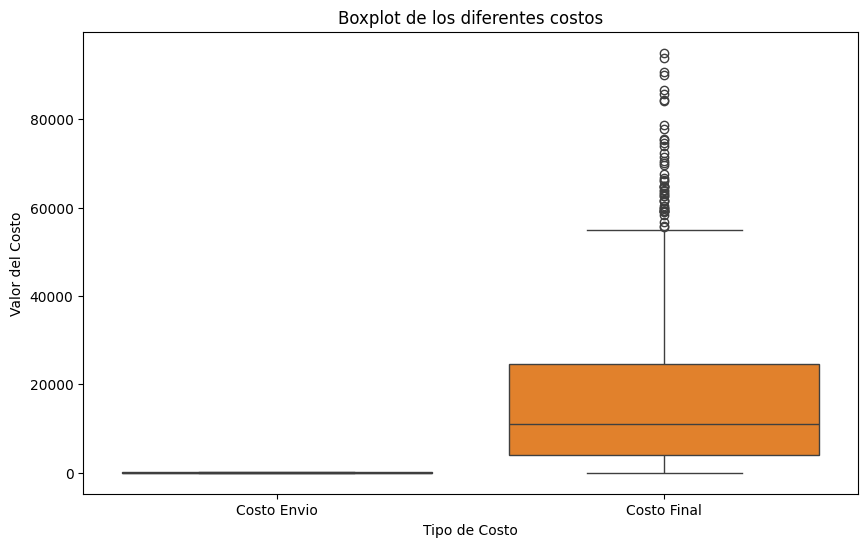

In [42]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_envio[['Costo Envio', 'Costo Final']])
plt.title('Boxplot de los diferentes costos')
plt.xlabel('Tipo de Costo')
plt.ylabel('Valor del Costo')
plt.show()

**Análisis del diagrama de caja**

El diagrama de caja  muestra la distribución de los costos de envío y los costos finales para diferentes tipos de costos. El diagrama de caja está dividido en cinco partes:

* **Caja:** La caja representa el rango intercuartílico (IQR) de los datos. El IQR es el rango que contiene el 50% central de los datos. La línea central de la caja representa la mediana de los datos.
* **Bigotes:** Los bigotes se extienden desde la caja hasta el máximo y mínimo de los datos que no son valores atípicos. Los valores atípicos se muestran como puntos individuales fuera de los bigotes.
* **Etiqueta del eje Y:** La etiqueta del eje Y muestra el valor del costo.
* **Etiqueta del eje X:** La etiqueta del eje X muestra el tipo de costo.

**Interpretación del diagrama de caja**

* **Costo de envío:** El costo de envío tiene una distribución asimétrica hacia la derecha, lo que significa que la mayoría de los costos de envío son relativamente bajos, con algunos valores atípicos altos. La mediana del costo de envío es de aproximadamente $20.000.
* **Costo final:** El costo final tiene una distribución más simétrica que el costo de envío. La mediana del costo final es de aproximadamente $60.000.

**Comparación de costos**

"Los costos finales son generalmente más altos que los costos de envío. La diferencia entre los dos tipos de costos es más pronunciada para los valores atípicos, ya que los costos finales incluyen directamente descuentos, cantidad y precio unitario."

3. **Z-Score**


In [43]:
outliers = df_envio.copy()
outliers['Z-score'] = np.abs(stats.zscore(df_envio['Costo Final']))
outliers_zscore = outliers[outliers['Z-score'] > 3]
print("Outliers basandos en Z-score:")
outliers_zscore

Outliers basandos en Z-score:


,Cliente,Puntos Fidelidad,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Producto,Precio Unitario,Cantidad,Metodo Pago,Oferta,Descuento,Costo Final,Z-score
Envio Key,,,,,,,,,,,,,,,,,
95,Donni Fassmann,1.0,DHL,envio economico,central,15.15,2023-11-14,2023-12-13,2022-02-24,portable charger,1904.04,50,PayPal,Promoción de smartphones,4.78,90665.77,4.132628
184,Dione Donohue,81.0,UPS,envio estandar,mountain,19.47,2023-07-01,2024-05-31,2019-03-23,smart scale,1967.08,50,Efectivo,Descuento en productos de audio y video,27.40,71419.14,3.050134
213,Tessy Gosnold,24.0,FedEx,envio estandar,suburb,77.74,2023-09-06,2023-09-10,2022-05-26,printer,1791.05,42,Tarjeta de crédito,Unknown,0.00,75301.84,3.268510
226,Earvin Taffley,62.0,Amazon Logistics,envio economico,central,15.15,2024-02-23,2023-12-16,2022-12-08,headphones,1995.27,47,Tarjeta de crédito,Unknown,0.00,93792.84,4.308505
252,Rosana Authers,11.0,FedEx,envio estandar,forest,79.73,2024-02-18,2023-10-04,2019-05-15,satellite phone,1998.13,45,PayPal,Unknown,0.00,89995.58,4.094935
309,Dorie Mathan,28.0,FedEx,envio expreso,desert,24.40,2023-07-23,2023-08-24,2021-07-09,gaming mouse,1863.13,42,PayPal,Promoción de smartphones,4.78,74534.27,3.225339
528,Rorie Barras,55.0,UPS,envio economico,desert,24.40,2023-07-08,2023-06-20,2020-01-02,smartwatch,1822.95,47,Efectivo,Unknown,0.00,85703.05,3.853509
597,Aurthur Jardine,91.0,USPS,envio estandar,forest,79.73,2023-10-12,2023-10-26,2019-04-12,robot vacuum,1939.55,40,Transferencia bancaria,Promoción de smartphones,4.78,73949.50,3.192450
621,Alvan Dangl,35.0,DHL,envio expreso,forest,79.73,2024-05-23,2024-02-24,2021-11-27,video baby monitor,1924.30,45,PayPal,Unknown,0.00,86673.23,3.908075


4. **Z-Score modificado**


In [44]:
def modified_zscore(series):
    median = np.median(series)
    mad = np.median(np.abs(series - median))
    return 0.6745 * (series - median) / mad


outliers['Modified Z-score'] = modified_zscore(outliers['Costo Final'])
outliers_modified_zscore = outliers[outliers['Modified Z-score'] > 3.5]
print("Outliers basandos en Modified Z-score:")
outliers_modified_zscore

Outliers basandos en Modified Z-score:


,Cliente,Puntos Fidelidad,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Producto,Precio Unitario,Cantidad,Metodo Pago,Oferta,Descuento,Costo Final,Z-score,Modified Z-score
Envio Key,,,,,,,,,,,,,,,,,,
91,Thaine Ralls,72.0,USPS,envio expreso,central,15.15,2024-03-18,2024-01-15,2020-09-07,network switch,1807.99,37,Tarjeta de crédito,Promoción de smartphones,4.78,63712.44,2.616684,4.139307
95,Donni Fassmann,1.0,DHL,envio economico,central,15.15,2023-11-14,2023-12-13,2022-02-24,portable charger,1904.04,50,PayPal,Promoción de smartphones,4.78,90665.77,4.132628,6.253091
184,Dione Donohue,81.0,UPS,envio estandar,mountain,19.47,2023-07-01,2024-05-31,2019-03-23,smart scale,1967.08,50,Efectivo,Descuento en productos de audio y video,27.40,71419.14,3.050134,4.743696
213,Tessy Gosnold,24.0,FedEx,envio estandar,suburb,77.74,2023-09-06,2023-09-10,2022-05-26,printer,1791.05,42,Tarjeta de crédito,Unknown,0.00,75301.84,3.268510,5.048193
222,Ezechiel Busch,4.0,UPS,envio economico,island,87.07,2024-01-16,2024-03-06,2021-05-24,biometric scanner,1579.68,41,Efectivo,Unknown,0.00,64853.95,2.680886,4.228829
226,Earvin Taffley,62.0,Amazon Logistics,envio economico,central,15.15,2024-02-23,2023-12-16,2022-12-08,headphones,1995.27,47,Tarjeta de crédito,Unknown,0.00,93792.84,4.308505,6.498328
232,Ronda Yushankin,69.0,USPS,envio economico,downtown,80.77,2024-02-01,2023-09-27,2019-12-04,keyboard,1293.39,46,Tarjeta de crédito,Promoción de smartphones,4.78,56728.94,2.223908,3.591634
252,Rosana Authers,11.0,FedEx,envio estandar,forest,79.73,2024-02-18,2023-10-04,2019-05-15,satellite phone,1998.13,45,PayPal,Unknown,0.00,89995.58,4.094935,6.200532
254,Alex Pietrusiak,83.0,DHL,envio expreso,mountain,19.47,2024-04-20,2023-07-27,2023-04-29,smartwatch,1893.31,37,Tarjeta de crédito,Unknown,0.00,70071.94,2.974363,4.638044


- Presentación de los outliers


In [45]:
outliers[['Cliente', 'Producto', 'Cantidad',"Precio Unitario", "Descuento",
          "Costo Envio","Costo Final",  'Z-score', 'Modified Z-score']].head(11)

,Cliente,Producto,Cantidad,Precio Unitario,Descuento,Costo Envio,Costo Final,Z-score,Modified Z-score
Envio Key,,,,,,,,,
1,Muffin Baudinot,digital voice recorder,38,957.59,0.00,87.07,36475.49,1.084787,2.003281
2,Tamera McAvaddy,wearable camera,22,625.85,49.08,87.07,7055.36,0.569899,-0.303959
3,Casey Arney,smart pen,33,925.57,24.07,24.40,23210.44,0.338716,0.962984
4,Tonnie Douthwaite,network switch,23,519.64,0.00,81.20,12032.92,0.289944,0.086400
5,Robbert Manueli,POS system,21,1858.28,4.78,24.40,37181.77,1.124510,2.058670
7,Halley Malmar,gaming console,10,1857.78,24.07,42.02,14138.03,0.171546,0.251491
8,Krystal Vivien,portable charger,1,1046.07,24.07,15.68,806.19,0.921373,-0.794043
9,Beale McAnulty,GPS device,28,1476.11,4.78,19.47,39373.99,1.247808,2.230592
10,Mischa Sheridan,smart thermostat,26,1409.16,4.78,79.73,34962.77,0.999707,1.884647


### Análisis de los primeros 10 registros en cuanto a Z-score y Modified Z-score

1. **Z-score**:
   - Es una medida estadística que describe la relación de un valor con la media de un grupo de valores. Se calcula como el número de desviaciones estándar que un valor está por encima o por debajo de la media.
   - En esta tabla, los z-scores están entre aproximadamente -1.25 y 1.25, lo que sugiere que los valores están bastante cerca de la media (dentro de 1 a 2 desviaciones estándar).

2. **Modified Z-score**:
   - Es una alternativa robusta al z-score, menos afectada por los valores atípicos. Utiliza la mediana y la desviación absoluta de la mediana (MAD).
   - En la tabla, los modified z-scores varían más ampliamente (-0.851230 a 2.230592), indicando algunas variaciones significativas en los datos, lo que sugiere la presencia de posibles valores atípicos.

### Observaciones específicas:

- **Muffin Baudinot** y **Robbert Manueli** tienen z-scores y modified z-scores relativamente altos (alrededor de 1.084787 y 2.003281 para Muffin Baudinot; 1.124510 y 2.058670 para Robbert Manueli), indicando costos finales altos comparados con otros registros.
- **Tamera McAvaddy** tiene un modified z-score negativo (-0.303959), lo que podría sugerir un costo final relativamente bajo comparado con la media, a pesar de que su z-score es positivo (0.569899).
- **Beale McAnulty** tiene el modified z-score más alto (2.230592), indicando que su costo final es uno de los más extremos en comparación con los otros registros.
- **Garfield Pouck** tiene un z-score y un modified z-score negativo (-0.851230), reflejando un costo final significativamente bajo.


5. **Rango intercuartílico**


In [46]:
Q1 = df_envio['Costo Final'].quantile(0.25)
Q3 = df_envio['Costo Final'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1: {Q1}")
print(f"Q3: {Q3}")
print(f"IQR: {IQR}")
print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")

outliers_iqr = df_envio[(df_envio['Costo Final'] < lower_bound) | (
    df_envio['Costo Final'] > upper_bound)]
print("Outliers basados en IQR:")
outliers_iqr

Q1: 3916.0825
Q3: 24522.98
IQR: 20606.8975
Lower Bound: -26994.26375
Upper Bound: 55433.32625
Outliers basados en IQR:


,Cliente,Puntos Fidelidad,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Producto,Precio Unitario,Cantidad,Metodo Pago,Oferta,Descuento,Costo Final
Envio Key,,,,,,,,,,,,,,,,
91,Thaine Ralls,72.0,USPS,envio expreso,central,15.15,2024-03-18,2024-01-15,2020-09-07,network switch,1807.99,37,Tarjeta de crédito,Promoción de smartphones,4.78,63712.44
95,Donni Fassmann,1.0,DHL,envio economico,central,15.15,2023-11-14,2023-12-13,2022-02-24,portable charger,1904.04,50,PayPal,Promoción de smartphones,4.78,90665.77
184,Dione Donohue,81.0,UPS,envio estandar,mountain,19.47,2023-07-01,2024-05-31,2019-03-23,smart scale,1967.08,50,Efectivo,Descuento en productos de audio y video,27.40,71419.14
213,Tessy Gosnold,24.0,FedEx,envio estandar,suburb,77.74,2023-09-06,2023-09-10,2022-05-26,printer,1791.05,42,Tarjeta de crédito,Unknown,0.00,75301.84
222,Ezechiel Busch,4.0,UPS,envio economico,island,87.07,2024-01-16,2024-03-06,2021-05-24,biometric scanner,1579.68,41,Efectivo,Unknown,0.00,64853.95
226,Earvin Taffley,62.0,Amazon Logistics,envio economico,central,15.15,2024-02-23,2023-12-16,2022-12-08,headphones,1995.27,47,Tarjeta de crédito,Unknown,0.00,93792.84
232,Ronda Yushankin,69.0,USPS,envio economico,downtown,80.77,2024-02-01,2023-09-27,2019-12-04,keyboard,1293.39,46,Tarjeta de crédito,Promoción de smartphones,4.78,56728.94
252,Rosana Authers,11.0,FedEx,envio estandar,forest,79.73,2024-02-18,2023-10-04,2019-05-15,satellite phone,1998.13,45,PayPal,Unknown,0.00,89995.58
254,Alex Pietrusiak,83.0,DHL,envio expreso,mountain,19.47,2024-04-20,2023-07-27,2023-04-29,smartwatch,1893.31,37,Tarjeta de crédito,Unknown,0.00,70071.94


### Análisis de los Datos de Outliers Basados en IQR

#### Parámetros del IQR:
- **Q1 (Primer Cuartil):** 3916.0825
- **Q3 (Tercer Cuartil):** 24522.98
- **IQR (Rango Intercuartílico):** 20606.8975
- **Límite Inferior:** -26994.26375 (Q1 - 1.5 * IQR)
- **Límite Superior:** 55433.32625 (Q3 + 1.5 * IQR)

Los outliers se identifican como puntos de datos que están por debajo del límite inferior o por encima del límite superior. En este caso, todos los valores de "Puntos de Fidelidad" están dentro del rango permitido por los límites inferior y superior, por lo que no se detectan outliers basados en estos límites.

#### Datos Proporcionados:
Los datos proporcionados incluyen varios registros de ventas, detallados por diferentes características como cliente, puntos de fidelidad, empresa de envío, método de envío, área, costo de envío, fechas (envío, entrega, pedido), producto, precio unitario, cantidad, método de pago, oferta, descuento y costo final.

### Observaciones:
1. **Distribución de Outliers:** Los clientes con puntos de fidelidad que se encuentran fuera del rango esperado se encuentran distribuidos a lo largo de diferentes empresas de envío, métodos de envío, y áreas. Esto sugiere que los outliers no están concentrados en una única categoría o tipo de envío.
   
2. **Método de Pago y Ofertas:** La mayoría de las transacciones con costos finales elevados utilizan promociones de smartphones, y hay una diversidad en los métodos de pago (Tarjeta de crédito, PayPal, Efectivo, Transferencia bancaria).

3. **Productos y Cantidades:** Los productos varían significativamente, desde cargadores portátiles hasta impresoras y proyectores, y las cantidades oscilan entre 30 y 50 unidades, lo que influye directamente en el costo final de la transacción.

4. **Costo Final Elevado:** Los costos finales de las transacciones fuera del rango son generalmente altos, lo que indica que los outliers identificados tienden a ser pedidos de gran volumen o productos costosos.

> # Etapa 5: Correlación de variables:


### 1. **Correlación entre la categoría del producto y la región de venta (area)**


In [47]:
contingency_table = pd.crosstab(df_envio['Producto'], df_envio['Area'])

# Realizar la prueba de chi-cuadrado
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Mostrar los resultados de la prueba de chi-cuadrado
print("Tabla de Contingencia:")
contingency_table

Tabla de Contingencia:


Area,central,coastal,desert,downtown,forest,island,mountain,rural,suburb,valley
Producto,,,,,,,,,,
Bluetooth tracker,3,3,2,1,3,1,2,1,0,2
GPS device,2,0,2,3,2,1,5,2,2,4
POS system,2,2,2,2,2,0,0,6,5,1
RFID reader,1,1,3,0,2,2,0,3,2,3
USB hub,5,1,4,1,1,2,3,1,5,2
VR headset,1,3,4,1,1,2,2,0,3,3
action camera,2,2,2,2,3,0,3,1,2,2
barcode scanner,0,1,0,2,2,3,0,0,0,0
biometric scanner,6,1,3,2,1,2,0,6,0,1



Resultados de la prueba de Chi-cuadrado:
Chi-cuadrado: 424.3096422582482
p-valor: 0.5950221985330891
Grados de libertad: 432


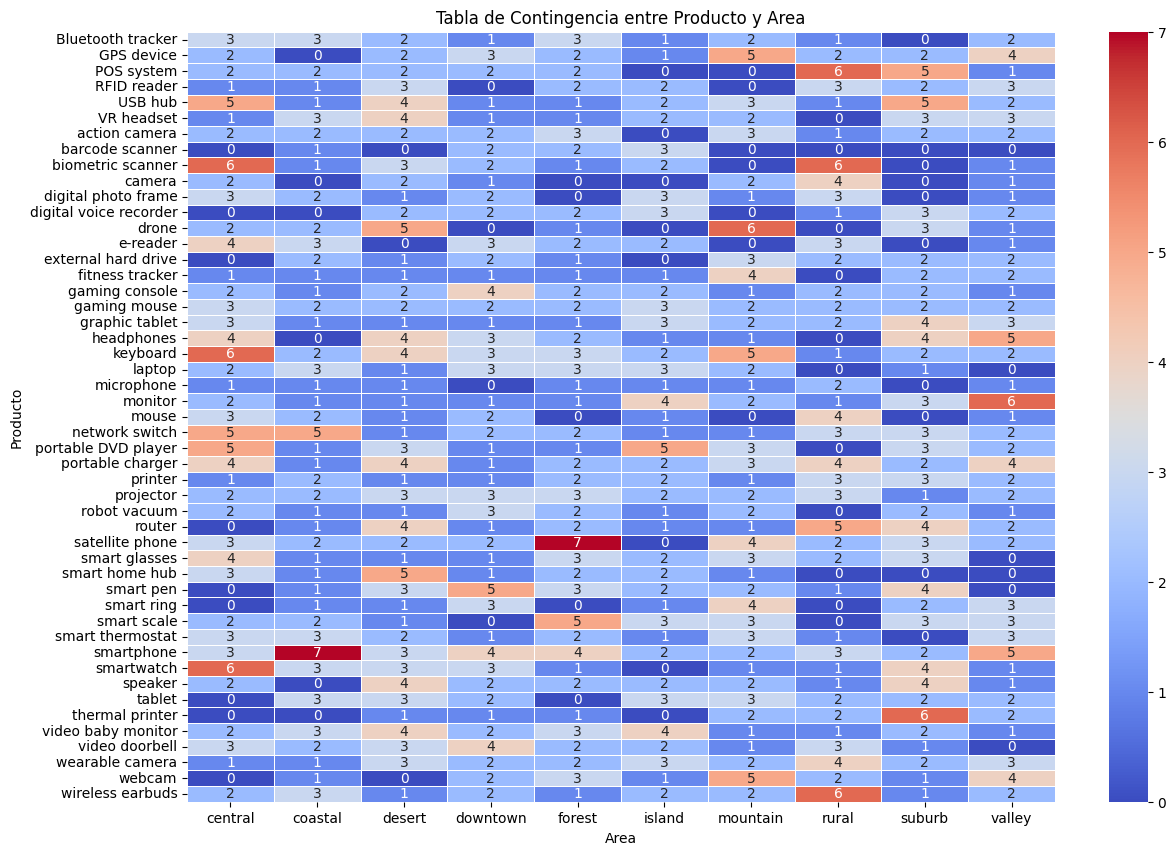

In [48]:
print("\nResultados de la prueba de Chi-cuadrado:")
print(f"Chi-cuadrado: {chi2}")
print(f"p-valor: {p}")
print(f"Grados de libertad: {dof}")
# Visualizar la tabla de contingencia usando un mapa de calor
plt.figure(figsize=(14, 10))
sns.heatmap(contingency_table, annot=True,
            cmap='coolwarm', linewidths=0.5, fmt='d')
plt.title('Tabla de Contingencia entre Producto y Area')
plt.show()

### De la correlacion entre dos variables:

1. **Productos más vendidos por región**:
   - **Central**: Bluetooth tracker, USB hub, e-reader, headphones, keyboard, smartwatch.
   - **Coastal**: Network switch, smartwatch.
   - **Desert**: Drone, smart home hub, USB hub, VR headset.
   - **Downtown**: GPS device, gaming console, smartphone, video doorbell, smart pen.
   - **Forest**: GPS device, barcode scanner, wearable camera.
   - **Island**: Monitor, portable DVD player, digital photo frame, video baby monitor.
   - **Mountain**: GPS device, drones, external hard drive, satellite phone.
   - **Rural**: POS system, keyboard, smart pen, wireless earbuds.
   - **Suburb**: POS system, USB hub, network switch, portable charger.
   - **Valley**: Bluetooth tracker, GPS device, headphones, monitor, webcam.

2. **Áreas con alta demanda general**:
   - **Central**: Alta demanda de una variedad de productos tecnológicos.
   - **Downtown**: Preferencia por gaming consoles y smartphones.
   - **Mountain**: Alta demanda de GPS y drones.
   - **Rural**: Alta compra de POS systems y teclados.

3. **Conclusiones clave**:
   - Diferentes áreas tienen preferencias específicas para ciertos productos.
   - Información útil para la planificación de inventarios y estrategias de marketing.
   - Focalizar esfuerzos de ventas en regiones donde ciertos productos tienen alta demanda puede maximizar ventas y eficiencia.

### **2. Correlacion**

Matriz de correlación de envios:
                  Puntos Fidelidad  Costo Envio  Precio Unitario  Cantidad  \
Puntos Fidelidad          1.000000    -0.073661         0.035252 -0.037915   
Costo Envio              -0.073661     1.000000        -0.031408  0.006079   
Precio Unitario           0.035252    -0.031408         1.000000  0.069720   
Cantidad                 -0.037915     0.006079         0.069720  1.000000   
Descuento                 0.012852    -0.025554        -0.011071 -0.000652   
Costo Final              -0.008878    -0.025363         0.613152  0.595197   

                  Descuento  Costo Final  
Puntos Fidelidad   0.012852    -0.008878  
Costo Envio       -0.025554    -0.025363  
Precio Unitario   -0.011071     0.613152  
Cantidad          -0.000652     0.595197  
Descuento          1.000000    -0.336309  
Costo Final       -0.336309     1.000000  


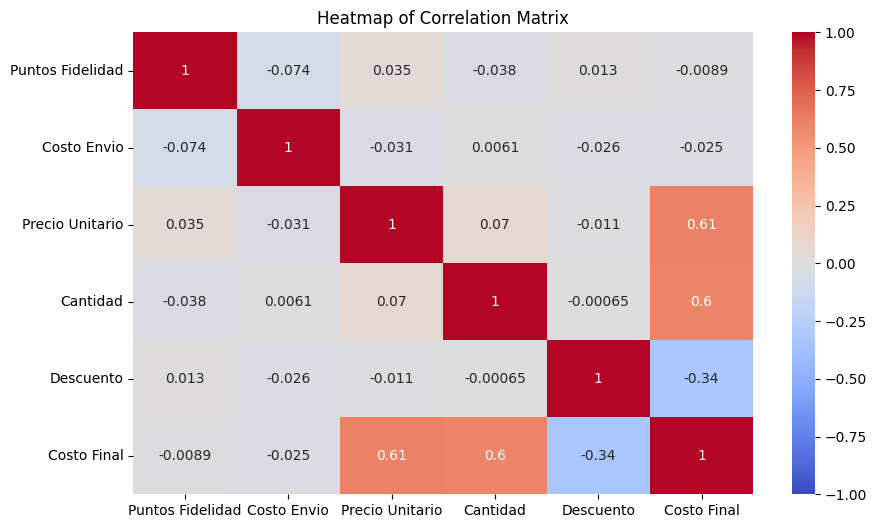

In [49]:

correlation_matrix = df_envio[['Puntos Fidelidad', 'Costo Envio', 'Precio Unitario', 'Cantidad', 'Descuento', 'Costo Final']].corr()
print("Matriz de correlación de envios:")
print(correlation_matrix)

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlation Matrix')
plt.show()


La Matriz de correlación  representa la correlación entre seis variables:

* **Puntos Fidelidad:** El número de puntos de fidelidad que tiene un cliente.
* **Costo Envio:** El costo de envío de un pedido.
* **Precio Unitario:** El precio de cada unidad de un producto.
* **Cantidad:** La cantidad de unidades de un producto que se piden.
* **Descuento:** El porcentaje de descuento que se aplica a un pedido.
* **Costo Final:** El costo final de un pedido, después de considerar todos los demás factores.

Los valores de correlación en la matriz varían de -1 a 1. Una correlación de 1 indica una correlación positiva perfecta, lo que significa que las dos variables siempre aumentan o disminuyen juntas. Una correlación de -1 indica una correlación negativa perfecta, lo que significa que las dos variables siempre aumentan en direcciones opuestas. Una correlación de 0 indica que no hay correlación entre las dos variables.

En esta matriz de correlación, se pueden observar las siguientes correlaciones:

* **Puntos Fidelidad y Costo Final:** Existe una correlación negativa moderada entre los puntos de fidelidad y el costo final. Esto significa que a medida que los puntos de fidelidad aumentan, el costo final tiende a disminuir. Esto se debe a que los puntos de fidelidad se pueden canjear por descuentos en pedidos.
* **Costo Envio y Costo Final:** Existe una correlación negativa débil entre el costo de envío y el costo final. Esto significa que a medida que el costo de envío aumenta, el costo final tiende a disminuir. Esto se puede deber a que los clientes con pedidos más grandes suelen tener derecho a envío gratuito o con descuento.
* **Precio Unitario y Costo Final:** Existe una correlación positiva moderada entre el precio unitario y el costo final. Esto significa que a medida que el precio unitario aumenta, el costo final también tiende a aumentar. Esto es de esperar, ya que el precio unitario es uno de los principales determinantes del costo final.
* **Cantidad y Costo Final:** Existe una correlación positiva fuerte entre la cantidad y el costo final. Esto significa que a medida que la cantidad aumenta, el costo final también tiende a aumentar. Esto también es de esperar, ya que un pedido con más unidades tendrá un costo final más alto.
* **Descuento y Costo Final:** Existe una correlación negativa fuerte entre el descuento y el costo final. Esto significa que a medida que el descuento aumenta, el costo final tiende a disminuir. Esto se debe a que el descuento reduce el precio total del pedido.

**Recomendaciones:**

TecnoNic puede utilizar esta información para desarrollar estrategias de marketing y ventas más efectivas. Por ejemplo, podrían:

* Ofrecer descuentos a los clientes con altos niveles de puntos de fidelidad.
* Ofrecer envío gratuito o con descuento a los clientes que realizan pedidos grandes.
* Ajustar los precios de los productos en función de la demanda y la competencia.
* Implementar programas de fidelización que recompensen a los clientes por sus compras.

> # Etapa 6: Visualización de datos :


# Anteriormente usamos Matplotlib y Seaborn para la visualización, pero en este caso utilizaremos el módulo de EDASQL.

- Definir eda


In [50]:
eda = edaSQL.EDA(dataFrame=df_envio, HTMLDisplay=True)

### 1. **Analisis univariado**


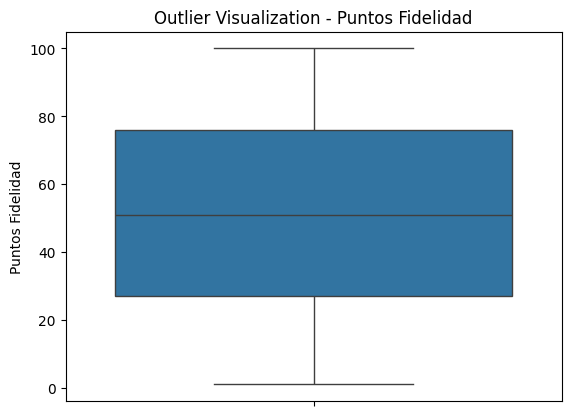

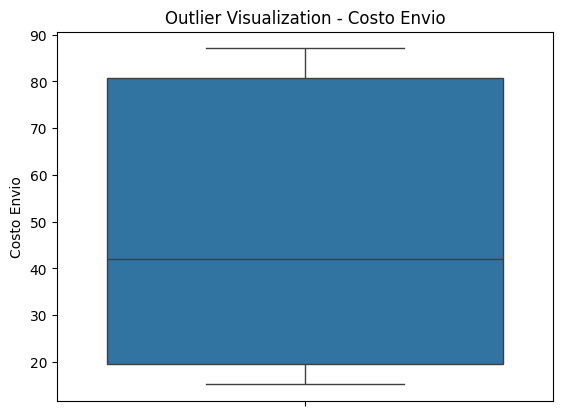

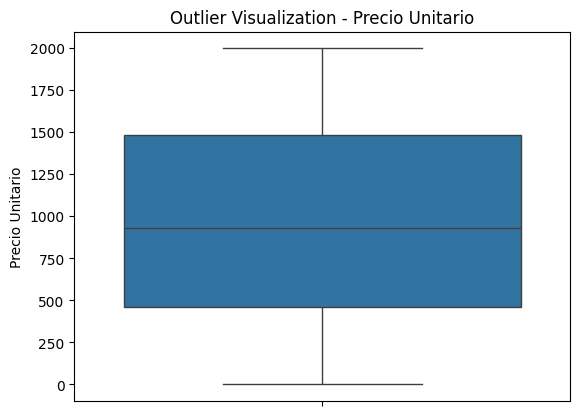

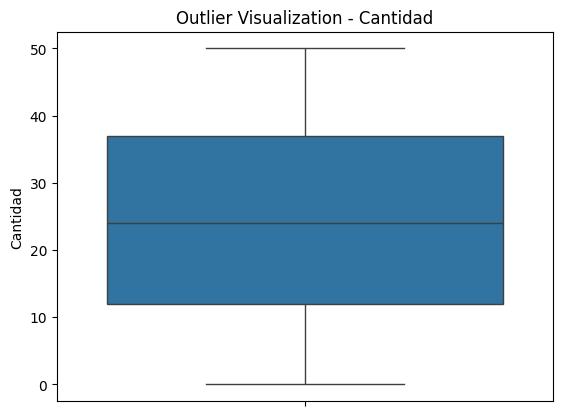

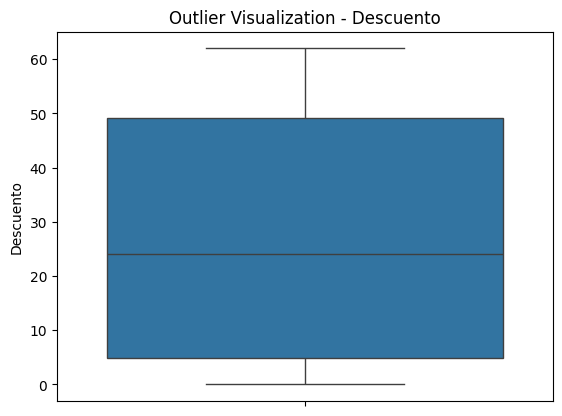

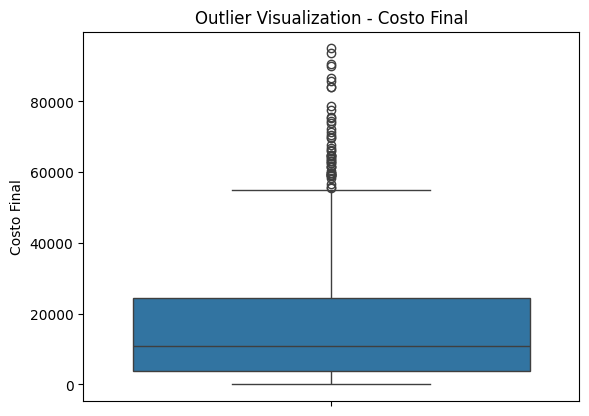

In [51]:
eda.outliersVisualization(plot="box")

### 2. **Analsis Bivariado**


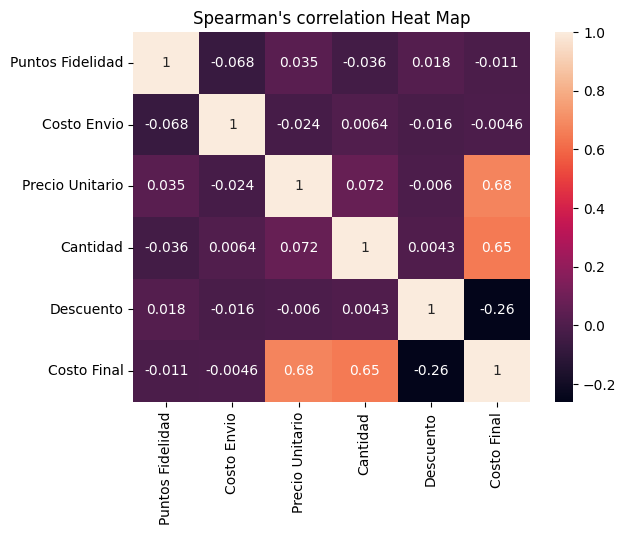

In [52]:
eda.spearmanCorrelation()

**Análisis del mapa de calor de Spearman**

**Interpretación de los valores de correlación**

* **Puntos Fidelidad:**
    * **Costo Envio:** La correlación es negativa y débil (-0.068). Esto significa que a medida que aumenta el número de puntos fidelidad, el costo de envío tiende a disminuir.
    * **Precio Unitario:** La correlación es débil y positiva (0.035). Esto significa que no hay una relación clara entre el número de puntos fidelidad y el precio unitario.
    * **Cantidad:** La correlación es débil y negativa (-0.036). Esto significa que a medida que aumenta el número de puntos fidelidad, la cantidad tiende a disminuir.
    * **Descuento:** La correlación es débil y positiva (0.018). Esto significa que no hay una relación clara entre el número de puntos fidelidad y el descuento.
    * **Costo Final:** La correlación es débil y negativa (-0.011). Esto significa que a medida que aumenta el número de puntos fidelidad, el costo final tiende a disminuir.

* **Costo Envio:**
    * **Precio Unitario:** La correlación es débil y negativa (-0.024). Esto significa que no hay una relación clara entre el costo de envío y el precio unitario.
    * **Cantidad:** La correlación es débil y positiva (0.0064). Esto significa que no hay una relación clara entre el costo de envío y la cantidad.
    * **Descuento:** La correlación es débil y negativa (-0.016). Esto significa que no hay una relación clara entre el costo de envío y el descuento.
    * **Costo Final:** La correlación es débil y negativa (-0.0046). Esto significa que a medida que aumenta el costo de envío, el costo final tiende a disminuir.

* **Precio Unitario:**
    * **Cantidad:** La correlación es débil y positiva (0.072). Esto significa que no hay una relación clara entre el precio unitario y la cantidad.
    * **Descuento:** La correlación es débil y negativa (-0.006). Esto significa que no hay una relación clara entre el precio unitario y el descuento.
    * **Costo Final:** La correlación es fuerte y positiva (0.68). Esto significa que a medida que aumenta el precio unitario, el costo final también aumenta.

* **Cantidad:**
    * **Descuento:** La correlación es débil y positiva (0.0043). Esto significa que no hay una relación clara entre la cantidad y el descuento.
    * **Costo Final:** La correlación es moderada y positiva (0.65). Esto significa que a medida que aumenta la cantidad, el costo final también aumenta.

* **Descuento:**
    * **Costo Final:** La correlación es débil y negativa (-0.26). Esto significa que a medida que aumenta el descuento, el costo final tiende a disminuir.

**Conclusiones**

En general, el mapa de calor de Spearman muestra que no hay una correlación fuerte entre la mayoría de las variables. Sin embargo, hay algunas correlaciones débiles que pueden ser de interés, como la correlación negativa entre el costo de envío y el número de puntos fidelidad, y la correlación fuerte y positiva entre el precio unitario y el costo final.

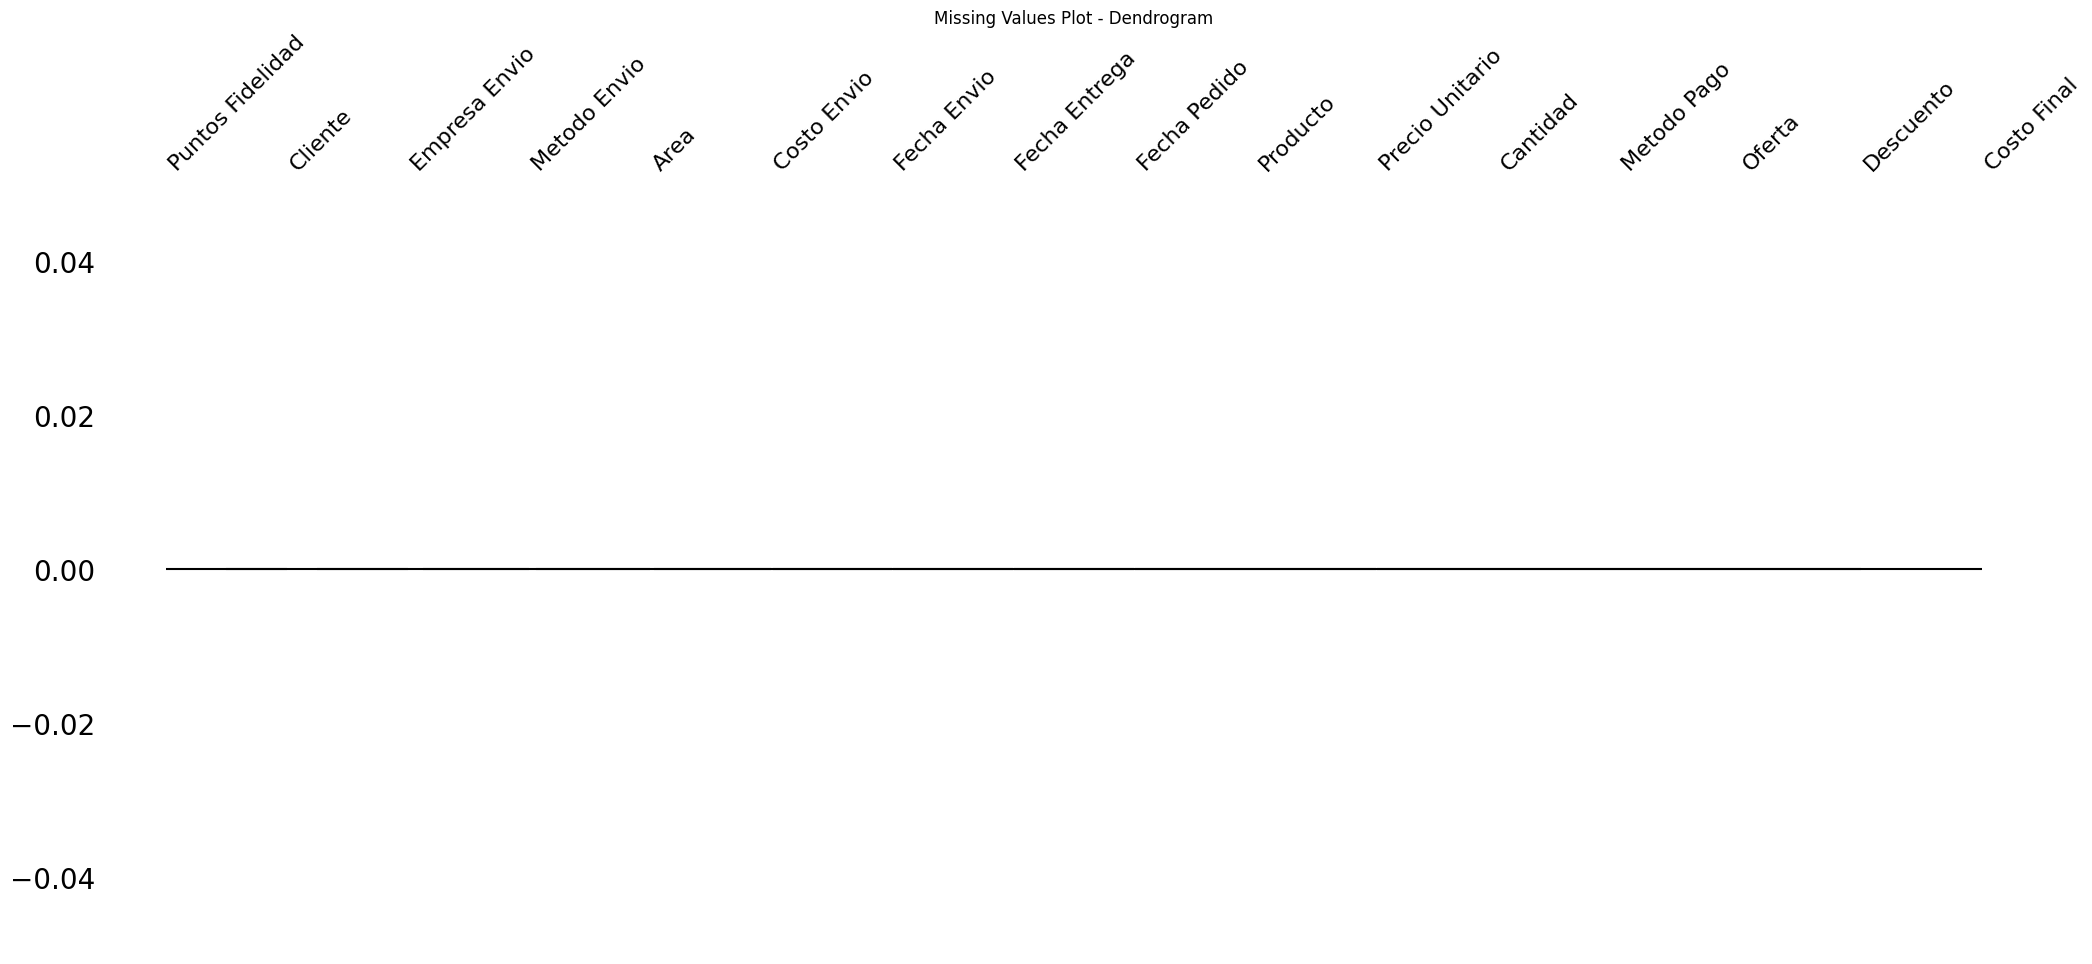

In [53]:
eda.missingValuesPlot(plot="dendrogram")

## Informe sobre la Calidad de los Datos: Análisis de Valores Faltantes

### Interpretación del Dendrograma

El dendrograma proporcionado muestra la relación entre las columnas del DataFrame con respecto a los valores faltantes. A continuación, se detallan las conclusiones derivadas de la interpretación del gráfico:

1. **No hay valores faltantes significativos**:

   - Observación: Todas las columnas están alineadas en el nivel 0 del eje Y.
   - Interpretación: Esta alineación sugiere que no hay valores faltantes significativos en ninguna de las columnas del DataFrame. Las columnas no presentan variabilidad en términos de datos ausentes, lo que indica una uniformidad en la completitud de los datos.

2. **Datos completos**:
   - Observación: La ausencia de agrupaciones o ramas distintas en el dendrograma.
   - Interpretación: La presencia de las columnas en el mismo nivel y sin formar agrupaciones o ramas separadas indica que las columnas del DataFrame tienen datos completos. No se observa ningún patrón distintivo de valores faltantes que destaque entre las diferentes columnas.

### Conclusión

El análisis del dendrograma revela que el DataFrame está compuesto por datos completos, sin valores faltantes significativos. Este resultado es ideal para el análisis de datos, ya que evita la necesidad de realizar tareas de imputación o eliminación de valores faltantes. Esto permite proceder con análisis más avanzados o el desarrollo de modelos de machine learning sin la preocupación de sesgos o inconsistencias introducidas por la ausencia de datos.


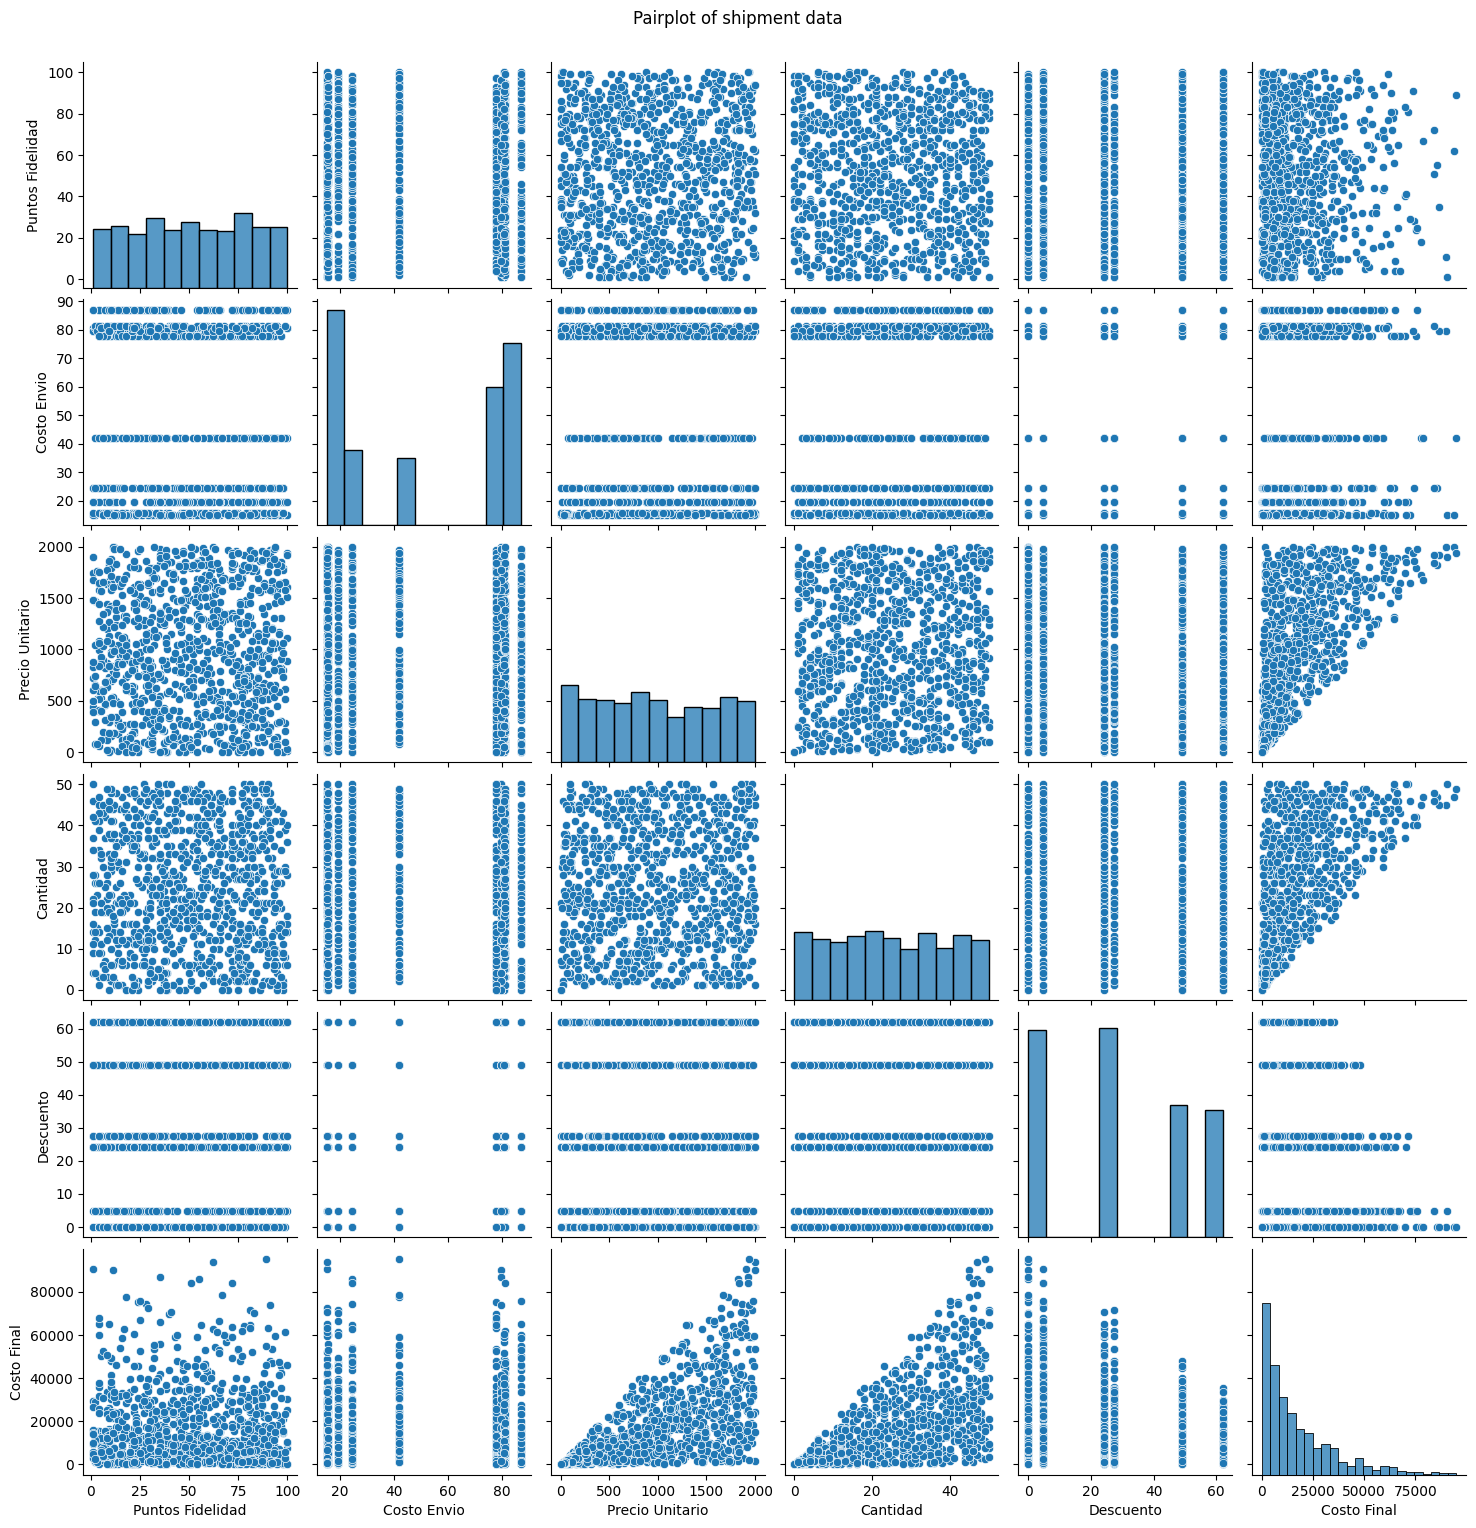

In [54]:
sns.pairplot(df_envio[['Puntos Fidelidad', 'Costo Envio', 'Precio Unitario', 'Cantidad', 'Descuento', 'Costo Final']])
plt.suptitle('Pairplot of shipment data', y=1.02)
plt.show()

# Informe de Análisis de Gráficos de Dispersión

## Gráfico 1: Puntos de Fidelidad

1. **Distribución de Puntos**: Los puntos están dispersos uniformemente a lo largo del gráfico, lo que sugiere que no hay un patrón claro en los "Puntos de Fidelidad" con respecto al índice.
2. **Rango de Valores**: El eje y (etiquetado como "Values") muestra que los "Puntos de Fidelidad" varían desde 0 hasta 100.
3. **Eje X (Índice)**: El eje x (etiquetado como "Index") parece representar la posición o índice de cada observación, que va de 0 a más de 600.
4. **Visualización de Outliers**: No se observan outliers obvios en este gráfico, ya que los puntos parecen estar uniformemente distribuidos dentro del rango esperado (0-100).

### Observaciones Clave:

- **No hay un patrón claro**: La dispersión uniforme de los puntos sugiere que los "Puntos de Fidelidad" no siguen un patrón discernible con respecto al índice.
- **Variabilidad de Datos**: Los "Puntos de Fidelidad" varían ampliamente, cubriendo todo el rango de 0 a 100.
- **Ausencia de Outliers Evidentes**: No hay puntos que se desvíen significativamente del rango general de valores, lo que sugiere que no hay valores atípicos destacados.

## Gráfico 2: Costo Envío

1. **Distribución de Puntos**: Los puntos en el gráfico están agrupados en varios niveles horizontales, lo que sugiere que el "Costo Envío" toma valores discretos específicos.
2. **Rango de Valores**: El eje y (etiquetado como "Values") muestra que los costos de envío varían desde 20 hasta 90.
3. **Eje X (Índice)**: El eje x (etiquetado como "Index") parece representar la posición o índice de cada observación, que va de 0 a más de 600.
4. **Patrones Horizontales**: Hay varias líneas horizontales distintivas que indican niveles comunes de costos de envío:
   - Alrededor de 20
   - Alrededor de 40
   - Alrededor de 80
   - Alrededor de 90

### Observaciones Clave:

- **Valores Discretos**: El "Costo Envío" parece estar limitado a ciertos valores discretos en lugar de ser continuo.
- **Niveles Comunes**: Los costos de envío más comunes están alrededor de 20, 40, 80,  y 90.
- **Agrupación Clara**: La agrupación de los puntos en líneas horizontales sugiere que hay tarifas estándar para el costo de envío en los datos.


## Gráfico 3: Precio Unitario

1. **Distribución de Datos**: Los puntos parecen estar distribuidos aleatoriamente en todo el rango de valores del eje Y (de 0 a 2000). No hay una clara concentración de puntos en una región específica.
2. **Densidad de Puntos**: Aunque los puntos están bastante dispersos, podemos notar algunas áreas con mayor densidad de puntos, lo que sugiere que ciertos rangos de precios unitarios ocurren con más frecuencia que otros.

## Gráfico 4: Cantidad

1. **Distribución de Datos**: Los puntos también parecen estar distribuidos aleatoriamente en todo el rango de valores del eje Y (de 0 a 50). No hay una clara concentración de puntos en una región específica.
2. **Identificación de Valores Atípicos**: Similar al gráfico anterior, los valores atípicos se identificarían buscando puntos que se desvíen significativamente del patrón general. A primera vista, no hay puntos que se destaquen claramente como outliers.
3. **Densidad de Puntos**: Aunque los puntos están dispersos, hay algunas áreas con una mayor concentración de puntos, lo que sugiere que ciertas cantidades ocurren con más frecuencia que otras.

En resumen, ambos gráficos muestran datos distribuidos de manera bastante uniforme sin patrones claros de agrupación o valores atípicos evidentes.

## Gráfico 5: Descuento

1. **Distribución de Datos**: A diferencia de los gráficos anteriores, los datos aquí parecen estar agrupados en dos niveles principales en el eje Y, uno alrededor de 5, otro alrededor de 25, de 50 y 60.
2. **Valores Atípicos**: Dado que los datos están agrupados en dos niveles claros, cualquier punto que no se alinee con estos niveles podría considerarse un outlier. Sin embargo, en este gráfico, no se observan claramente valores fuera de estos dos niveles.
3. **Patrones de Descuento**: Los datos sugieren que los descuentos se aplican en dos niveles distintos y específicos, posiblemente indicando dos políticas o categorías de descuento.

## Gráfico 6: Costo Final

1. **Distribución de Datos**: La mayoría de los puntos de datos se encuentran por debajo de los 20,000, lo que sugiere que la mayor parte de los costos finales están en ese rango.
2. **Outliers**: Se pueden observar algunos puntos que están significativamente más altos que el resto, alrededor de los 30,000 y 40,000. Estos puntos son outliers, ya que están fuera del rango donde se concentra la mayoría de los datos.
3. **Patrón de Dispersión**: No parece haber un patrón claro en la dispersión de los datos, indicando que los costos finales varían bastante en todos los índices.